In [1]:
%cd ..

d:\autograde


# Pre-Cutting image processing

In [2]:
import os 
import pandas as pd 
import numpy as np
# check if there is "data/created/training.csv"
if os.path.exists("data/created/training.csv"):
    df = pd.read_csv("data/created/training.csv")
    print("File loaded")
else: print("No csv file")

File loaded


## Delete duplicates

In [3]:
import pandas as pd
import os
from tqdm import tqdm
def read_label_file(file, directory):
    """
    Reads a YOLO format label file and returns its contents as a list of strings.
    """
    with open(os.path.join(directory, file), 'r') as f:
        data = f.readlines()
    return data

def write_label_file(file, directory, data):
    """
    Writes data to a YOLO format label file.
    """
    with open(os.path.join(directory, file), 'w') as f:
        f.writelines(data)

def are_lines_similar(line1, line2, threshold=0.01):
    """
    Compares two YOLO format lines to check if they are similar based on a threshold.
    """
    values1 = list(map(float, line1.split()))
    values2 = list(map(float, line2.split()))
    
    # Ensure they are of the same length
    if len(values1) != len(values2):
        return False

    # Compare each value with a threshold
    for v1, v2 in zip(values1[1:], values2[1:]):
        if abs(v1 - v2) > threshold:
            return False
    return True

def remove_duplicates(data, threshold=0.01):
    """
    Removes duplicates from YOLO format data based on a similarity threshold.
    """
    unique_lines = []
    for line in data:
        if not any(are_lines_similar(line, unique_line, threshold) for unique_line in unique_lines):
            unique_lines.append(line)
    return unique_lines

def process_dataframe(df, label_dir, output_dir,threshold=0.01):
    """
    Processes the dataframe to check for duplicates in YOLO files and updates the files.

    Args:
        df (pd.DataFrame): The dataframe containing the label file information.
        label_dir (str): The directory where label files are located.
        threshold (float): The similarity threshold for removing duplicates.

    Returns:
        None
    """
    for idx, row in tqdm(df.iterrows()):
        label_file = row['label_name']
        
        # Read the label file
        data = read_label_file(label_file, label_dir)
        
        # Remove duplicates
        cleaned_data = remove_duplicates(data, threshold)
        
        # Write back the cleaned data
        write_label_file(label_file, output_dir, cleaned_data)

In [4]:
output_dir = "data/created/processed_label/"

In [5]:
def process(df,start,end):
    df_start_end = df.iloc[start:end]
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print("Directory created")

    # check if there is the first txt file of df in output_dir
    if os.path.exists(output_dir + df_start_end['label_name'].iloc[0]):
        print("File already processed")
    else:
        label_dir = "data/Trainning_SET/Labels/"
        process_dataframe(df_start_end, label_dir,output_dir, threshold=0.01)

+ 2340->2599
+ 2600->2859
+ 2860->3119
+ 4420->4679

In [6]:
process(df,2340,2600)

File already processed


In [7]:
process(df,2600,2860)

File already processed


In [8]:
process(df,2860,3120)

File already processed


In [9]:
process(df,4420,4680)

File already processed


In [10]:
process(df,3380,3640)

File already processed


In [11]:
process(df,3640,3900)

File already processed


In [12]:
process(df,3900,4160)

File already processed


In [13]:
process(df,2080,2340)

File already processed


In [14]:
process(df,3120,3380)

File already processed


In [15]:
process(df,4160,4420)

File already processed


# Cutting image processing

### Testing

Backup created for IMG_1581_iter_0_SBD.txt in data/backup_labels
Processed IMG_1581_iter_0_SBD.txt:
 - Total labels after processing: 60
 - Number of labels set to class_id=2: 0
File: IMG_1581_iter_0_SBD.txt
Number of labels after removing duplicates and handling class conflicts: 60
Number of labels set to class_id=2: 0


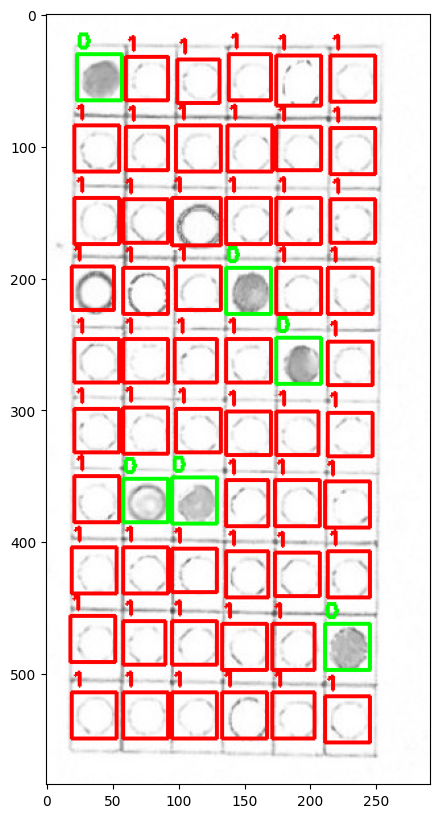

In [16]:
import os
import shutil
import cv2

def backup_label_file(label_file_path, backup_dir):
    """
    Creates a backup of the label file.

    Parameters:
        label_file_path (str): Path to the label file.
        backup_dir (str): Directory where backups will be stored.
    """
    if not os.path.exists(backup_dir):
        os.makedirs(backup_dir)
    shutil.copy(label_file_path, backup_dir)
    print(f"Backup created for {os.path.basename(label_file_path)} in {backup_dir}")

def process_single_label_file(label_file_name, cropped_label_dir, cropped_image_dir, backup_label_dir, threshold=0.5, decimal_places=6):
    """
    Processes a single label file to remove exact duplicates and handle overlapping labels with different classes.
    Replaces overlapping labels with different classes by a single label with class_id=2.

    Args:
        label_file_name (str): Name of the label file (e.g., "IMG_2265_iter_0_SBD.txt").
        cropped_label_dir (str): Directory containing the cropped label files.
        cropped_image_dir (str): Directory containing the cropped images.
        backup_label_dir (str): Directory to store backups.
        threshold (float): The IoU threshold for duplicate removal (unused in this version).
        decimal_places (int): Number of decimal places to round the coordinates for grouping.

    Returns:
        tuple: (list of cleaned labels, number of class_id=2 labels), or (None, None) if an error occurred.
    """
    label_path = os.path.join(cropped_label_dir, label_file_name)
    image_path = os.path.join(
        cropped_image_dir, label_file_name.replace(".txt", ".jpg")
    )  # Corresponding image path

    # Read image to get dimensions
    img = cv2.imread(image_path)
    if img is None:
        print(f"Warning: Could not read image {image_path}. Skipping label file.")
        return None, None
    img_height, img_width = img.shape[:2]

    try:
        with open(label_path, "r") as f:
            raw_labels = [line.strip() for line in f if line.strip()]
    except FileNotFoundError:
        print(f"Error: Label file not found: {label_path}")
        return None, None

    # Backup the original label file
    backup_label_file(label_path, backup_label_dir)

    # Dictionary to group labels by their rounded bounding box coordinates
    label_groups = {}
    for label in raw_labels:
        parts = label.split()
        if len(parts) != 5:
            print(f"Skipping malformed line in {label_file_name}: {label}")
            continue  # Skip malformed lines
        class_id, x_center_norm, y_center_norm, width_norm, height_norm = parts
        try:
            # Round coordinates to handle floating point precision
            key = (
                round(float(x_center_norm), decimal_places),
                round(float(y_center_norm), decimal_places),
                round(float(width_norm), decimal_places),
                round(float(height_norm), decimal_places)
            )
            if key not in label_groups:
                label_groups[key] = set()
            label_groups[key].add(class_id)
        except ValueError:
            print(f"Skipping line with invalid float values in {label_file_name}: {label}")
            continue  # Skip lines with invalid float values

    cleaned_labels = []
    class_id_2_count = 0

    for key, class_ids in label_groups.items():
        x_center_norm, y_center_norm, width_norm, height_norm = key
        if len(class_ids) == 1:
            # Only one class for this bounding box
            class_id = class_ids.pop()
            cleaned_label = f"{class_id} {x_center_norm:.6f} {y_center_norm:.6f} {width_norm:.6f} {height_norm:.6f}"
            cleaned_labels.append(cleaned_label)
        else:
            # Multiple classes for the same bounding box, replace with class_id=2
            cleaned_label = f"2 {x_center_norm:.6f} {y_center_norm:.6f} {width_norm:.6f} {height_norm:.6f}"
            cleaned_labels.append(cleaned_label)
            class_id_2_count += 1

    # Write the cleaned labels back to the file
    with open(label_path, 'w') as file:
        for line in cleaned_labels:
            file.write(line + '\n')

    print(f"Processed {label_file_name}:")
    print(f" - Total labels after processing: {len(cleaned_labels)}")
    print(f" - Number of labels set to class_id=2: {class_id_2_count}")

    return cleaned_labels, class_id_2_count

def draw_labels_on_image(cleaned_labels, cropped_label_dir, cropped_image_dir, label_file_name):
    """
    Draws bounding boxes and class IDs on the corresponding image based on the cleaned labels.

    Args:
        cleaned_labels (list): List of cleaned label strings.
        cropped_label_dir (str): Directory containing the cropped label files.
        cropped_image_dir (str): Directory containing the cropped images.
        label_file_name (str): Name of the label file.
    """
    label_path = os.path.join(cropped_label_dir, label_file_name)
    image_path = os.path.join(
        cropped_image_dir, label_file_name.replace(".txt", ".jpg")
    )  # Corresponding image path

    # Read the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Warning: Could not read image {image_path}. Skipping drawing.")
        return

    # Define colors for different class IDs (modify as needed)
    COLORS = {
        "0": (0, 255, 0),   # Green
        "1": (255, 0, 0),   # Blue
        "2": (0, 0, 255)    # Red for class_id=2
    }

    for label in cleaned_labels:
        parts = label.split()
        if len(parts) != 5:
            continue  # Skip malformed lines
        class_id, x_center_norm, y_center_norm, width_norm, height_norm = parts
        try:
            x_center = float(x_center_norm) * img.shape[1]
            y_center = float(y_center_norm) * img.shape[0]
            width = float(width_norm) * img.shape[1]
            height = float(height_norm) * img.shape[0]
            x1 = int(x_center - width / 2)
            y1 = int(y_center - height / 2)
            x2 = int(x1 + width)
            y2 = int(y1 + height)

            # Choose color based on class_id
            color = COLORS.get(class_id, (255, 255, 255))  # Default to white if class_id not defined

            # Draw rectangle
            cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

            # Put class_id text
            cv2.putText(
                img,
                str(int(float(class_id))),
                (x1, y1 - 5),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                color,
                2
            )
        except ValueError:
            print(f"Skipping label with invalid float values: {label}")
            continue  # Skip lines with invalid float values

    # Display the image using OpenCV's GUI (press any key to close)
    from data_engineering.pivot_contour import show_sheet
    show_sheet(img)

    # Alternatively, if you prefer to use a different display method or save the image, modify accordingly.
    # For example, to save the annotated image:
    # annotated_image_path = os.path.join(cropped_image_dir, f"annotated_{label_file_name.replace('.txt', '.jpg')}")
    # cv2.imwrite(annotated_image_path, img)
    # print(f"Annotated image saved to {annotated_image_path}")

# Example Usage for Processing a Single File
cropped_label_dir = "data/cropped_labels"    # Directory with cropped labels
cropped_image_dir = "data/cropped_images"    # Directory with cropped images
backup_label_dir = "data/backup_labels"      # Directory to store backups
label_file_name = "IMG_1581_iter_0_SBD.txt"  # Replace with your actual file name
threshold = 0.7                              # IoU threshold (unused in this version)

# Process the label file
cleaned_labels, num_class_id_2 = process_single_label_file(
    label_file_name,
    cropped_label_dir,
    cropped_image_dir,
    backup_label_dir,
    threshold=threshold,
    decimal_places=6
)

if cleaned_labels is not None:
    print(f"File: {label_file_name}")
    print(f"Number of labels after removing duplicates and handling class conflicts: {len(cleaned_labels)}")
    print(f"Number of labels set to class_id=2: {num_class_id_2}")

    # Draw the labels on the image
    draw_labels_on_image(cleaned_labels, cropped_label_dir, cropped_image_dir, label_file_name)
else:
    print(f"Error processing {label_file_name}")

## Process

### Duplicate

In [17]:
import os
import cv2
import csv
from tqdm import tqdm

def process_single_label_file(label_file_name, cropped_label_dir, decimal_places=6):
    """
    Processes a single label file to remove exact duplicates and handle overlapping labels with different classes.
    Replaces overlapping labels with different classes by a single label with class_id=2.

    Args:
        label_file_name (str): Name of the label file (e.g., "IMG_2265_iter_0_SBD.txt").
        cropped_label_dir (str): Directory containing the cropped label files.
        decimal_places (int): Number of decimal places to round the coordinates for grouping.

    Returns:
        tuple: (list of cleaned labels, number of class_id=2 labels, original label count)
    """
    label_path = os.path.join(cropped_label_dir, label_file_name)

    try:
        with open(label_path, "r") as f:
            raw_labels = [line.strip() for line in f if line.strip()]
    except FileNotFoundError:
        print(f"Error: Label file not found: {label_path}")
        return None, None, 0

    # Group labels by their rounded bounding box coordinates
    label_groups = {}
    for label in raw_labels:
        parts = label.split()
        if len(parts) != 5:
            print(f"Skipping malformed line in {label_file_name}: {label}")
            continue  # Skip malformed lines
        class_id, x_center_norm, y_center_norm, width_norm, height_norm = parts
        try:
            # Round coordinates to handle floating point precision
            key = (
                round(float(x_center_norm), decimal_places),
                round(float(y_center_norm), decimal_places),
                round(float(width_norm), decimal_places),
                round(float(height_norm), decimal_places)
            )
            if key not in label_groups:
                label_groups[key] = set()
            label_groups[key].add(class_id)
        except ValueError:
            print(f"Skipping line with invalid float values in {label_file_name}: {label}")
            continue  # Skip lines with invalid float values

    cleaned_labels = []
    class_id_2_count = 0

    for key, class_ids in label_groups.items():
        x_center_norm, y_center_norm, width_norm, height_norm = key
        if len(class_ids) == 1:
            # Only one class for this bounding box
            class_id = class_ids.pop()
            cleaned_label = f"{class_id} {x_center_norm:.6f} {y_center_norm:.6f} {width_norm:.6f} {height_norm:.6f}"
            cleaned_labels.append(cleaned_label)
        else:
            # Multiple classes for the same bounding box, replace with class_id=2
            cleaned_label = f"2 {x_center_norm:.6f} {y_center_norm:.6f} {width_norm:.6f} {height_norm:.6f}"
            cleaned_labels.append(cleaned_label)
            class_id_2_count += 1

    original_label_count = len(raw_labels)

    return cleaned_labels, class_id_2_count, original_label_count

def parse_label_file_name(label_file_name):
    """
    Parses the label file name to extract image_name, org_name, type, and label_name.

    Args:
        label_file_name (str): Name of the label file (e.g., "IMG_1581_iter_0_SBD.txt").

    Returns:
        tuple: (image_name, org_name, type, label_name)
    """
    base_name = label_file_name.rsplit('.', 1)[0]  # Remove extension
    parts = base_name.split('_')
    
    if len(parts) < 2:
        # Not enough parts to parse
        image_name = base_name + '.jpg'
        org_name = base_name + '.jpg'
        type_ = ''
    else:
        type_ = parts[-1]
        org_image_name = '_'.join(parts[:-1])
        image_name = base_name + '.jpg'
        org_name = org_image_name + '.jpg'
    
    label_name = label_file_name
    return image_name, org_name, type_, label_name

def remove_duplicate_labels(cropped_label_dir, output_label_dir, decimal_places=6, warning_threshold=65, warning_file_path="warnings.txt"):
    """
    Processes all YOLOv8 label files in a directory to remove duplicates and handle class conflicts.

    Args:
        cropped_label_dir (str): Directory containing the cropped label files.
        output_label_dir (str): Directory to save cleaned label files.
        decimal_places (int): Number of decimal places for rounding coordinates.
        warning_threshold (int): The bounding box count threshold to trigger a warning.
        warning_file_path (str): Path to the file where warnings will be logged.

    Returns:
        dict: A dictionary with label file names as keys and lists of cleaned labels as values.
    """
    if not os.path.exists(cropped_label_dir):
        print(f"The label directory {cropped_label_dir} does not exist.")
        return {}

    if not os.path.exists(output_label_dir):
        os.makedirs(output_label_dir)
        print(f"Output label directory {output_label_dir} created.")

    label_files = [f for f in os.listdir(cropped_label_dir) if f.endswith('.txt')]
    if not label_files:
        print(f"No label files found in {cropped_label_dir}.")
        return {}

    cleaned_labels_dict = {}
    class_id_2_total = 0
    warnings = []

    print(f"Processing {len(label_files)} label files...")

    for file_name in tqdm(label_files, desc="Processing Labels", unit="file"):
        cleaned_labels, num_class_id_2, original_label_count = process_single_label_file(
            file_name,
            cropped_label_dir,
            decimal_places=decimal_places
        )

        if cleaned_labels is not None:
            # Save cleaned labels to the output directory
            output_label_path = os.path.join(output_label_dir, file_name)
            with open(output_label_path, "w") as f:
                for label in cleaned_labels:
                    f.write(label + '\n')
            cleaned_labels_dict[file_name] = cleaned_labels

            # Update total count
            class_id_2_total += num_class_id_2

            # Conditional Logging: Only print if at least one label was set to class_id=2
            if num_class_id_2 > 0:
                print(f" - {file_name}: {len(cleaned_labels)} labels retained, {num_class_id_2} set to class_id=2")

            # Check for bounding box count exceeding the threshold after cleaning
            if len(cleaned_labels) > warning_threshold:
                warning_msg = f"Warning: {file_name} has {len(cleaned_labels)} bounding boxes after cleaning."
                warnings.append(warning_msg)
        else:
            print(f"Error processing {file_name}")


    # Write warnings to the warning file
    if warnings:
        # Ensure the directory for the warning file exists
        warning_dir = os.path.dirname(warning_file_path)
        if warning_dir and not os.path.exists(warning_dir):
            os.makedirs(warning_dir)
        with open(warning_file_path, "w") as wf:
            for warning in warnings:
                wf.write(warning + '\n')
        print(f"\nWarnings saved to {warning_file_path}")
    else:
        print("\nNo files exceeded the bounding box count threshold after cleaning.")

    return cleaned_labels_dict

def update_csv(cleaned_labels_dict, csv_path):
    """
    Updates a CSV file with information about the cleaned label files.

    Args:
        cleaned_labels_dict (dict): Dictionary with label file names as keys and lists of cleaned labels as values.
        csv_path (str): Path to the CSV file to be updated.
    """
    csv_headers = ["image_name", "org_name", "type", "label_name", "number_label", "num_class_id_2"]
    rows = []

    for label_file, labels in cleaned_labels_dict.items():
        image_name, org_name, type_, label_name = parse_label_file_name(label_file)
        num_labels = len(labels)
        num_class_id_2 = sum(1 for label in labels if label.startswith("2 "))
        rows.append([image_name, org_name, type_, label_name, num_labels, num_class_id_2])

    # Ensure the directory for the CSV file exists
    csv_dir = os.path.dirname(csv_path)
    if csv_dir and not os.path.exists(csv_dir):
        os.makedirs(csv_dir)

    # Write to CSV
    with open(csv_path, "w", newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(csv_headers)
        writer.writerows(rows)

    print(f"CSV file updated at {csv_path}")

def process_and_save_all(cropped_label_dir, output_label_dir, csv_path, decimal_places=6, warning_threshold=65, warning_file_path="warnings.txt"):
    """
    Main function to process all label files, remove duplicates, handle class conflicts, save cleaned labels,
    and update CSV.

    Args:
        cropped_label_dir (str): Directory containing the cropped label files.
        output_label_dir (str): Directory to save cleaned label files.
        csv_path (str): Path to the CSV file to be updated.
        decimal_places (int): Number of decimal places for rounding coordinates.
        warning_threshold (int): The bounding box count threshold to trigger a warning.
        warning_file_path (str): Path to the file where warnings will be logged.
    """
    # 1. Remove Duplicate Labels and Handle Class Conflicts
    cleaned_labels = remove_duplicate_labels(
        cropped_label_dir,
        output_label_dir,
        decimal_places=decimal_places,
        warning_threshold=warning_threshold,
        warning_file_path=warning_file_path
    )

    if not cleaned_labels:
        print("No labels were cleaned. Exiting.")
        return

    # 2. Update CSV with Cleaned Labels Information
    update_csv(cleaned_labels, csv_path)

    print("\nDuplicate labels removed and cleaned label files saved.")

In [18]:
RERUN = False
if RERUN:
    cropped_label_dir = "data/cropped_labels"         # Directory with cropped labels
    output_label_dir = "data/noduplicate_labels"      # Directory to save cleaned label files
    csv_path = "data/noduplicate_cropped_data.csv"    # Path to the CSV file
    warning_file_path = "data/warnings.txt"           # Path to save warnings

    # Parameters
    decimal_places = 6        # Number of decimal places for rounding coordinates
    warning_threshold = 65     # Bounding box count threshold for warnings

    # Process all files and save cleaned labels
    process_and_save_all(
        cropped_label_dir=cropped_label_dir,
        output_label_dir=output_label_dir,
        csv_path=csv_path,
        decimal_places=decimal_places,
        warning_threshold=warning_threshold,
        warning_file_path=warning_file_path
    )


### Redundant

In [19]:
if os.path.exists("data/noduplicate_cropped_data.csv"):
    df = pd.read_csv("data/noduplicate_cropped_data.csv")
    print("File loaded")

File loaded


In [20]:
df

image_name             org_name  type  \
0      IMG_1581_iter_0_1.00.jpg  IMG_1581_iter_0.jpg  1.00   
1      IMG_1581_iter_0_1.10.jpg  IMG_1581_iter_0.jpg  1.10   
2      IMG_1581_iter_0_1.20.jpg  IMG_1581_iter_0.jpg  1.20   
3      IMG_1581_iter_0_1.30.jpg  IMG_1581_iter_0.jpg  1.30   
4      IMG_1581_iter_0_2.00.jpg  IMG_1581_iter_0.jpg  2.00   
...                         ...                  ...   ...   
83195  IMG_3958_iter_9_3.03.jpg  IMG_3958_iter_9.jpg  3.03   
83196  IMG_3958_iter_9_3.04.jpg  IMG_3958_iter_9.jpg  3.04   
83197  IMG_3958_iter_9_3.05.jpg  IMG_3958_iter_9.jpg  3.05   
83198   IMG_3958_iter_9_MDT.jpg  IMG_3958_iter_9.jpg   MDT   
83199   IMG_3958_iter_9_SBD.jpg  IMG_3958_iter_9.jpg   SBD   

                     label_name  number_label  num_class_id_2  
0      IMG_1581_iter_0_1.00.txt            40               0  
1      IMG_1581_iter_0_1.10.txt            40               0  
2      IMG_1581_iter_0_1.20.txt            40               0  
3      IMG_1581_iter_0_1.30.txt            40               0  
4      IMG_1581_iter_0_2.00.txt            16               0  
...                         ...           ...             ...  
83195  IMG_3958_iter_9_3.03.txt            43               0  
83196  IMG_3958_iter_9_3.04.txt            43               0  
83197  IMG_3958_iter_9_3.05.txt            43               0  
83198   IMG_3958_iter_9_MDT.txt            30               0  
83199   IMG_3958_iter_9_SBD.txt            60               0  

[83200 rows x 6 columns]

In [21]:
# calculate the number of file in a directory
directory = "data/std_num_bbox_labels"
if os.path.exists(directory):
    num_files = len([f for f in os.listdir(directory) if f.endswith('.txt')])
    print(f"Number of files in {directory}: {num_files}")

Number of files in data/std_num_bbox_labels: 83200


In [23]:
df["standard_number_label"] = df["type"].apply(lambda x: 60 if x == "SBD" else 30 if x == "MDT" else 40 if x in ["1.00", "1.10", "1.20", "1.30"] else 16 if x in ["2.00", "2.02", "2.04", "2.06"] else 43 if x in ["3.00", "3.01", "3.02", "3.03", "3.04", "3.05"] else None)

#### 1.20

##### Testing

In [113]:
newdf = df[df["standard_number_label"] < df["number_label"]]
newdf[newdf.type=="1.20"].head()

image_name               org_name  type  \
49922    IMG_2269_iter_0_1.20.jpg    IMG_2269_iter_0.jpg  1.20   
49938  IMG_2269_iter_100_1.20.jpg  IMG_2269_iter_100.jpg  1.20   
49954  IMG_2269_iter_101_1.20.jpg  IMG_2269_iter_101.jpg  1.20   
49970  IMG_2269_iter_102_1.20.jpg  IMG_2269_iter_102.jpg  1.20   
49986  IMG_2269_iter_103_1.20.jpg  IMG_2269_iter_103.jpg  1.20   

                       label_name  number_label  num_class_id_2  \
49922    IMG_2269_iter_0_1.20.txt            41              18   
49938  IMG_2269_iter_100_1.20.txt            41              16   
49954  IMG_2269_iter_101_1.20.txt            41              14   
49970  IMG_2269_iter_102_1.20.txt            41              14   
49986  IMG_2269_iter_103_1.20.txt            41              16   

       standard_number_label  
49922                     40  
49938                     40  
49954                     40  
49970                     40  
49986                     40

In [76]:
newdf.type.value_counts()

type
3.00    520
3.04    260
1.20    260
3.01    260
Name: count, dtype: int64

You can check the [web 5](image_reader/web5.py) for more details.

In [114]:
df_120 = newdf[newdf.type=="1.20"]

In [115]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

def display_first_entry(newdf, cropped_image_dir, output_label_dir,id=0):
    """
    Displays the first image in 'newdf' with drawn bounding boxes based on the label file.

    Args:
        newdf (pd.DataFrame): DataFrame containing image and label information.
        cropped_image_dir (str): Directory containing the original images.
        output_label_dir (str): Directory containing the cleaned label files.
    """
    if newdf.empty:
        print("The provided DataFrame 'newdf' is empty. Exiting function.")
        return

    # Retrieve the first entry
    first_entry = newdf.iloc[id]

    # Extract necessary fields
    image_name = first_entry['image_name']
    label_name = first_entry['label_name']

    # Construct full paths
    image_path = os.path.join(cropped_image_dir, image_name)
    label_path = os.path.join(output_label_dir, label_name)

    # Check if image exists
    if not os.path.exists(image_path):
        print(f"Error: Image file '{image_path}' does not exist.")
        return

    # Check if label file exists
    if not os.path.exists(label_path):
        print(f"Error: Label file '{label_path}' does not exist.")
        return

    # Load the image using OpenCV
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Failed to read image '{image_path}'.")
        return

    # Read and parse the label file
    try:
        with open(label_path, "r") as f:
            labels = [line.strip() for line in f if line.strip()]
    except Exception as e:
        print(f"Error reading label file '{label_path}': {e}")
        return

    # Iterate over each label and draw bounding boxes
    for label in labels:
        parts = label.split()
        if len(parts) != 5:
            print(f"Skipping malformed label: '{label}' in '{label_name}'")
            continue  # Skip malformed lines

        class_id, x_center_norm, y_center_norm, width_norm, height_norm = parts

        try:
            # Convert normalized coordinates to absolute pixel values
            x_center = float(x_center_norm) * image.shape[1]
            y_center = float(y_center_norm) * image.shape[0]
            width = float(width_norm) * image.shape[1]
            height = float(height_norm) * image.shape[0]

            # Calculate top-left and bottom-right coordinates
            x1 = int(x_center - width / 2)
            y1 = int(y_center - height / 2)
            x2 = int(x1 + width)
            y2 = int(y1 + height)

            # Define colors for different class IDs
            # You can customize this dictionary based on your class IDs and desired colors
            COLORS = {
                "0": (0, 255, 0),    # Green
                "1": (255, 0, 0),    # Blue
                "2": (0, 0, 255),    # Red
                # Add more class IDs and colors as needed
            }

            color = COLORS.get(class_id, (255, 255, 255))  # Default to white if class_id not defined

            # Draw the bounding box
            cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

            # Put the class ID text above the bounding box
            cv2.putText(
                image,
                class_id,
                (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                color,
                2
            )

        except ValueError:
            print(f"Skipping label with invalid float values: '{label}' in '{label_name}'")
            continue  # Skip labels with invalid float values

    # Convert BGR image (OpenCV) to RGB (Matplotlib)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image using Matplotlib
    plt.figure(figsize=(12, 12))
    plt.imshow(image_rgb)
    plt.title(f"Image: {image_name} | Label File: {label_name}")
    plt.axis('off')
    plt.show()

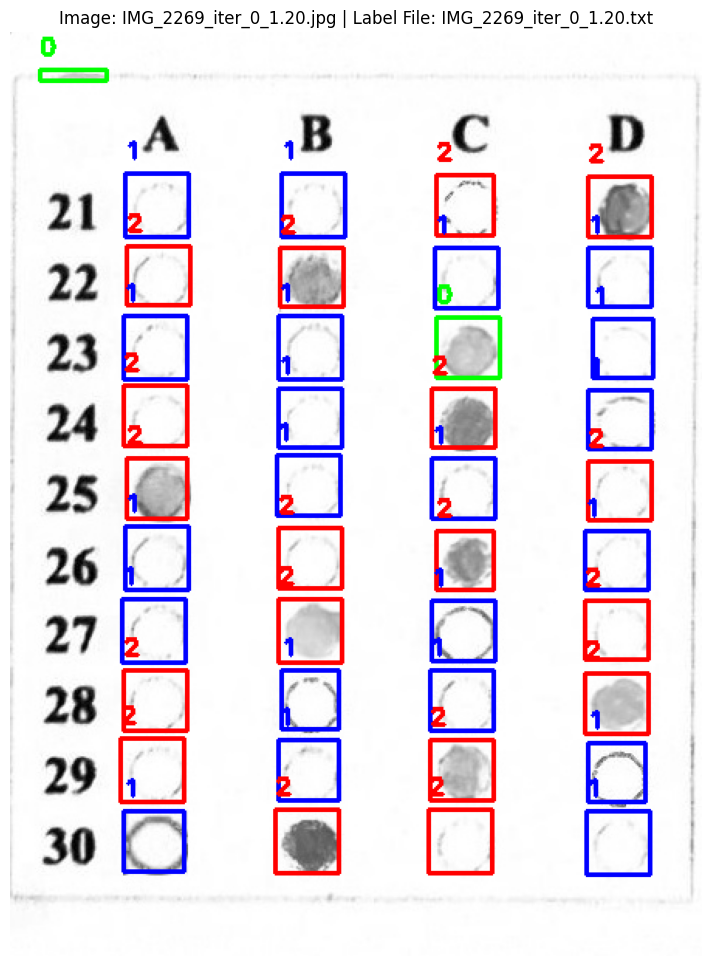

In [116]:
# Define directories
cropped_image_dir = "data/cropped_images"         # Directory with original images
output_label_dir = "data/noduplicate_labels"
display_first_entry(df_120, cropped_image_dir, output_label_dir)

In [117]:
import os

def sort_and_remove_top_bbox(label_path, output_label_path):
    """
    Sorts bounding boxes from top to bottom and removes the topmost bounding box.
    
    Args:
        label_path (str): Path to the original label file.
        output_label_path (str): Path to save the updated label file.
    """
    try:
        with open(label_path, 'r') as f:
            labels = [line.strip() for line in f if line.strip()]
    except FileNotFoundError:
        print(f"Error: Label file not found: {label_path}")
        return
    
    # Parse labels into a list of tuples (class_id, x_center_norm, y_center_norm, width_norm, height_norm)
    parsed_labels = []
    for label in labels:
        parts = label.split()
        if len(parts) != 5:
            print(f"Skipping malformed label: '{label}' in '{label_path}'")
            continue  # Skip malformed lines
        class_id, x_center_norm, y_center_norm, width_norm, height_norm = parts
        try:
            y_center_norm_float = float(y_center_norm)
            parsed_labels.append((class_id, x_center_norm, y_center_norm_float, width_norm, height_norm))
        except ValueError:
            print(f"Skipping label with invalid float values: '{label}' in '{label_path}'")
            continue  # Skip labels with invalid float values
    
    if not parsed_labels:
        print(f"No valid bounding boxes found in '{label_path}'.")
        return
    
    # Sort labels based on y_center_norm (ascending: top to bottom)
    sorted_labels = sorted(parsed_labels, key=lambda x: x[2])
    
    # Remove the first bounding box (topmost)
    cleaned_labels = sorted_labels[1:]
    
    # Convert back to string format
    cleaned_labels_str = [f"{cls} {float(x):.6f} {float(y):.6f} {float(w):.6f} {float(h):.6f}"
                     for cls, x, y, w, h in cleaned_labels]
    
    # Save the cleaned labels
    with open(output_label_path, 'w') as f:
        for label in cleaned_labels_str:
            f.write(label + '\n')
    
    print(f"Updated label file saved to {output_label_path}. Total labels retained: {len(cleaned_labels_str)}")

In [118]:
import cv2
import matplotlib.pyplot as plt

def display_image_with_labels(image_path, label_path):
    """
    Reads an image and its corresponding label file, draws bounding boxes, and displays the image.
    
    Args:
        image_path (str): Path to the image file.
        label_path (str): Path to the label file.
    """
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not read image '{image_path}'.")
        return

    # Read and parse the label file
    try:
        with open(label_path, "r") as f:
            labels = [line.strip() for line in f if line.strip()]
    except FileNotFoundError:
        print(f"Error: Label file '{label_path}' not found.")
        return

    # Get image dimensions
    img_height, img_width = image.shape[:2]

    # Define colors for different class IDs
    COLORS = {
        "0": (0, 255, 0),    # Green
        "1": (255, 0, 0),    # Blue
        "2": (0, 0, 255)     # Red
        # Add more class IDs and colors as needed
    }

    for label in labels:
        parts = label.split()
        if len(parts) != 5:
            print(f"Skipping malformed label: '{label}' in '{label_path}'")
            continue
        class_id, x_center_norm, y_center_norm, width_norm, height_norm = parts

        try:
            # Convert normalized coordinates to absolute pixel values
            x_center = float(x_center_norm) * img_width
            y_center = float(y_center_norm) * img_height
            width = float(width_norm) * img_width
            height = float(height_norm) * img_height

            # Calculate top-left and bottom-right coordinates
            x1 = int(x_center - width / 2)
            y1 = int(y_center - height / 2)
            x2 = int(x1 + width)
            y2 = int(y1 + height)

            # Choose color based on class_id
            color = COLORS.get(class_id, (255, 255, 255))  # Default to white if class_id not defined

            # Draw rectangle
            cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

            # Put class_id text above the bounding box
            cv2.putText(
                image,
                str(int(float(class_id))),
                (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                color,
                2
            )
        except ValueError:
            print(f"Skipping label with invalid float values: '{label}' in '{label_path}'")
            continue

    # Convert BGR image (OpenCV) to RGB (Matplotlib)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image using Matplotlib
    plt.figure(figsize=(12, 12))
    plt.imshow(image_rgb)
    plt.title(os.path.basename(image_path))
    plt.axis('off')
    plt.show()


In [119]:
import pandas as pd

def process_and_display_first_entry(dfnew, cropped_image_dir, output_label_dir,id=0):
    """
    Processes the first entry in dfnew by sorting bounding boxes, removing the topmost one, and displaying the updated image.
    
    Args:
        dfnew (pd.DataFrame): DataFrame containing image and label information.
        cropped_image_dir (str): Directory containing the original images.
        output_label_dir (str): Directory containing the cleaned label files.
    """
    if dfnew.empty:
        print("The DataFrame 'dfnew' is empty. Exiting function.")
        return

    # Retrieve the first entry
    first_entry = dfnew.iloc[id]

    # Extract necessary fields
    image_name = first_entry['image_name']
    label_name = first_entry['label_name']

    # Construct full paths
    image_path = os.path.join(cropped_image_dir, image_name)
    original_label_path = os.path.join(output_label_dir, label_name)
    updated_label_path = os.path.join("data/trash", f"updated_{label_name}")

    # Sort bounding boxes and remove the topmost one
    sort_and_remove_top_bbox(
        label_path=original_label_path,
        output_label_path=updated_label_path
    )

    # Update the DataFrame with the new number of labels
    try:
        with open(updated_label_path, 'r') as f:
            updated_labels = [line.strip() for line in f if line.strip()]
    except FileNotFoundError:
        print(f"Error: Updated label file '{updated_label_path}' not found.")
        return

    # Display the updated image
    display_image_with_labels(image_path=image_path, label_path=updated_label_path)

Updated label file saved to data/trash\updated_IMG_2269_iter_0_1.20.txt. Total labels retained: 40


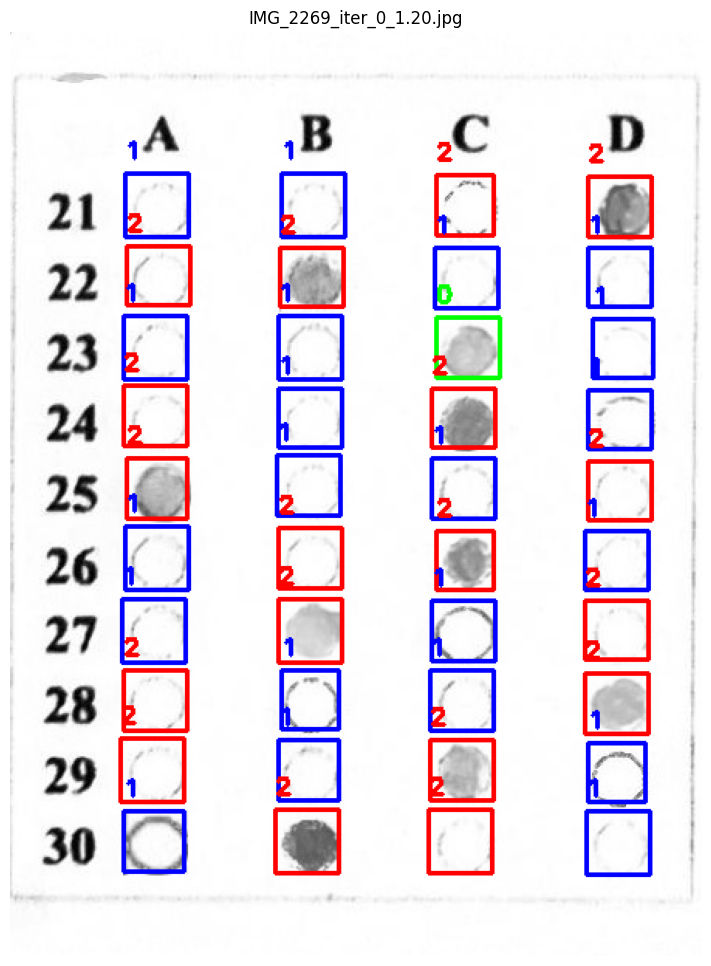

In [120]:
cropped_image_dir = "data/cropped_images"         # Directory with original images
output_label_dir = "data/noduplicate_labels"      # Directory with cleaned label files

# Process and display the first entry
process_and_display_first_entry(df_120, cropped_image_dir, output_label_dir,0)

##### Process


In [121]:
def sort_and_remove_top_bbox(label_path, output_label_path):
    """
    Sorts bounding boxes from top to bottom based on y_center_norm and removes the topmost bounding box.
    
    Args:
        label_path (str): Path to the original label file.
        output_label_path (str): Path to save the updated label file.
        
    Returns:
        int: Number of bounding boxes retained after removal.
             Returns -1 if the label file is not found.
             Returns 0 if no valid bounding boxes are found.
    """
    try:
        with open(label_path, 'r') as f:
            labels = [line.strip() for line in f if line.strip()]
    except FileNotFoundError:
        print(f"Error: Label file not found: {label_path}")
        return -1  # Indicate failure to process
    
    # Parse labels into a list of tuples
    parsed_labels = []
    for label in labels:
        parts = label.split()
        if len(parts) != 5:
            print(f"Skipping malformed label: '{label}' in '{label_path}'")
            continue  # Skip malformed lines
        class_id, x_center_norm, y_center_norm, width_norm, height_norm = parts
        try:
            y_center_norm_float = float(y_center_norm)
            parsed_labels.append((class_id, x_center_norm, y_center_norm_float, width_norm, height_norm))
        except ValueError:
            print(f"Skipping label with invalid float values: '{label}' in '{label_path}'")
            continue  # Skip labels with invalid float values
    
    if not parsed_labels:
        print(f"No valid bounding boxes found in '{label_path}'.")
        return 0  # Indicate no labels processed
    
    # Sort labels based on y_center_norm (ascending: top to bottom)
    sorted_labels = sorted(parsed_labels, key=lambda x: x[2])
    
    # Remove the first bounding box (topmost)
    cleaned_labels = sorted_labels[1:]
    
    # Convert back to string format with six decimal places
    cleaned_labels_str = [
        f"{cls} {float(x):.6f} {float(y):.6f} {float(w):.6f} {float(h):.6f}"
        for cls, x, y, w, h in cleaned_labels
    ]
    
    # Save the cleaned labels
    with open(output_label_path, 'w') as f:
        for label in cleaned_labels_str:
            f.write(label + '\n')
    
    print(f"Updated label file saved to '{output_label_path}'. Total labels retained: {len(cleaned_labels_str)}")
    return len(cleaned_labels_str)  # Return the number of labels retained

def process_bulk_labels(df, input_label_dir, output_label_dir):
    """
    Processes all label files listed in the DataFrame by sorting bounding boxes vertically,
    removing the topmost one, and saving the updated labels to the output directory.
    
    Args:
        df (pd.DataFrame): DataFrame containing image and label information.
        input_label_dir (str): Directory containing the original label files.
        output_label_dir (str): Directory to save the updated label files.
    
    Returns:
        int: Number of label files successfully processed.
    """
    processed_count = 0
    skipped_count = 0  # To track files that couldn't be processed
    
    for idx, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing Labels"):
        label_name = row['label_name']
        input_label_path = os.path.join(input_label_dir, label_name)
        output_label_path = os.path.join(output_label_dir, label_name)  # Keeping the same file name
    
        retained_labels = sort_and_remove_top_bbox(input_label_path, output_label_path)
        if retained_labels > 0:
            # Update the DataFrame with the new number of labels
            df.at[idx, 'number_label'] = retained_labels
            df.at[idx, 'standard_number_label'] = retained_labels  # Adjust if needed
            processed_count += 1
        elif retained_labels == 0:
            print(f"No labels retained after processing '{label_name}'.")
            df.at[idx, 'number_label'] = 0
            df.at[idx, 'standard_number_label'] = 0
            skipped_count += 1
        else:
            print(f"Failed to process label file: {label_name}")
            skipped_count += 1
    
    print(f"\nBulk processing completed. Total files processed: {processed_count}")
    if skipped_count > 0:
        print(f"Total files skipped or failed to process: {skipped_count}")
    
    return processed_count


In [122]:
if RERUN:
    # Define directories
    input_label_dir = "data/noduplicate_labels"            # Directory with original label files
    output_label_dir = "data/std_num_bbox_labels"          # Directory to save updated label files
    csv_output_path = "data/df_120_updated.csv"            # Path to save the updated CSV file

    # Create the output directory if it doesn't exist
    if not os.path.exists(output_label_dir):
        os.makedirs(output_label_dir)
        print(f"Created output directory: '{output_label_dir}'")
    else:
        print(f"Output directory already exists: '{output_label_dir}'")

    # Process all label files
    processed_files = process_bulk_labels(df_120, input_label_dir, output_label_dir)
    print(f"\nBulk processing completed. Total files processed: {processed_files}")

    # Save the updated DataFrame to a new CSV
    df_120.to_csv(csv_output_path, index=False)
    print(f"Saved the updated DataFrame to '{csv_output_path}'")

Output directory already exists: 'data/std_num_bbox_labels'


Processing Labels:   5%|▍         | 12/260 [00:00<00:02, 111.99it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_0_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_100_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_101_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_102_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_103_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_104_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_105_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_106_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_107_1.20.txt'. Total labels retained: 40
Updated label file sa

Processing Labels:  13%|█▎        | 35/260 [00:00<00:02, 108.51it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_11_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_120_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_121_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_122_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_123_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_124_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_125_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_126_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_127_1.20.txt'. Total labels retained: 40
Updated label file s

Processing Labels:  22%|██▏       | 58/260 [00:00<00:01, 108.59it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_140_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_141_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_142_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_143_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_144_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_145_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_146_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_147_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_148_1.20.txt'. Total labels retained: 40
Updated label file 

Processing Labels:  31%|███       | 80/260 [00:00<00:01, 100.71it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_161_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_162_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_163_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_164_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_165_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_166_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_167_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_168_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_169_1.20.txt'. Total labels retained: 40
Updated label file 

Processing Labels:  40%|███▉      | 103/260 [00:00<00:01, 105.90it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_180_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_181_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_182_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_183_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_184_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_185_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_186_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_187_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_188_1.20.txt'. Total labels retained: 40
Updated label file 

Processing Labels:  44%|████▍     | 114/260 [00:01<00:01, 101.74it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_1_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_200_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_201_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_202_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_203_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_204_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_205_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_206_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_207_1.20.txt'. Total labels retained: 40
Updated label file sa

Processing Labels:  52%|█████▏    | 135/260 [00:01<00:01, 89.21it/s] 

Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_212_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_213_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_214_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_215_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_216_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_217_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_218_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_219_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_21_1.20.txt'. Total labels retained: 40
Updated label file s

Processing Labels:  60%|██████    | 157/260 [00:01<00:01, 97.01it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_230_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_231_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_232_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_233_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_234_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_235_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_236_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_237_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_238_1.20.txt'. Total labels retained: 40
Updated label file 

Processing Labels:  68%|██████▊   | 177/260 [00:01<00:00, 93.70it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_249_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_24_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_250_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_251_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_252_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_253_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_254_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_255_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_256_1.20.txt'. Total labels retained: 40
Updated label file s

Processing Labels:  77%|███████▋  | 199/260 [00:01<00:00, 100.94it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_32_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_33_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_34_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_35_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_36_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_37_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_38_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_39_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_3_1.20.txt'. Total labels retained: 40
Updated label file saved to '

Processing Labels:  85%|████████▌ | 221/260 [00:02<00:00, 98.33it/s] 

Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_52_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_53_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_54_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_55_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_56_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_57_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_58_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_59_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_5_1.20.txt'. Total labels retained: 40
Updated label file saved to '

Processing Labels:  93%|█████████▎| 241/260 [00:02<00:00, 87.09it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_69_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_6_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_70_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_71_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_72_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_73_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_74_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_75_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_76_1.20.txt'. Total labels retained: 40
Updated label file saved to '

Processing Labels:  96%|█████████▌| 250/260 [00:02<00:00, 86.67it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_83_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_84_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_85_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_86_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_87_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_88_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_89_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_8_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_90_1.20.txt'. Total labels retained: 40
Updated label file saved to '

Processing Labels: 100%|██████████| 260/260 [00:02<00:00, 94.56it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_98_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_99_1.20.txt'. Total labels retained: 40
Updated label file saved to 'data/std_num_bbox_labels\IMG_2269_iter_9_1.20.txt'. Total labels retained: 40

Bulk processing completed. Total files processed: 260

Bulk processing completed. Total files processed: 260
Saved the updated DataFrame to 'data/df_120_updated.csv'


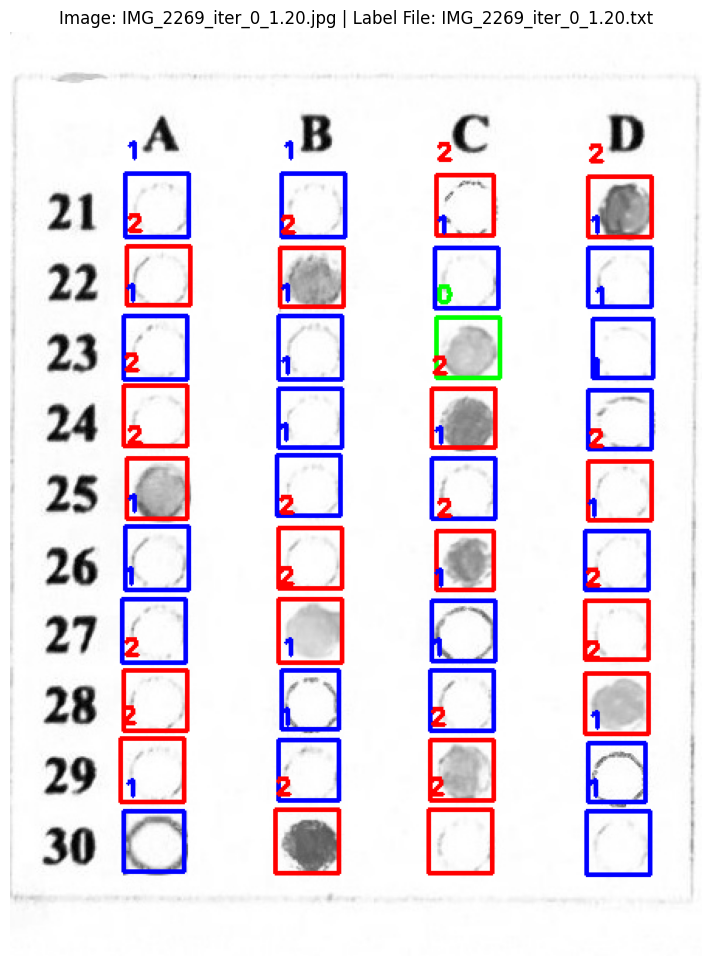

In [123]:
# check with data/std_num_bbox_labels\IMG_2273_iter_9_3.00.txt'

# Load and display the updated label file for the first entry in df_44.

df_120 = pd.read_csv("data/df_120_updated.csv")
df_120.head()

cropped_image_dir = "data/cropped_images"         # Directory with original images
output_label_dir = "data/std_num_bbox_labels"
display_first_entry(df_120, cropped_image_dir, output_label_dir)


#### 45

In [36]:
newdf = df[df["standard_number_label"] < df["number_label"]]
newdf[newdf.number_label==45].number_label.value_counts()

number_label
45    260
Name: count, dtype: int64

##### testing

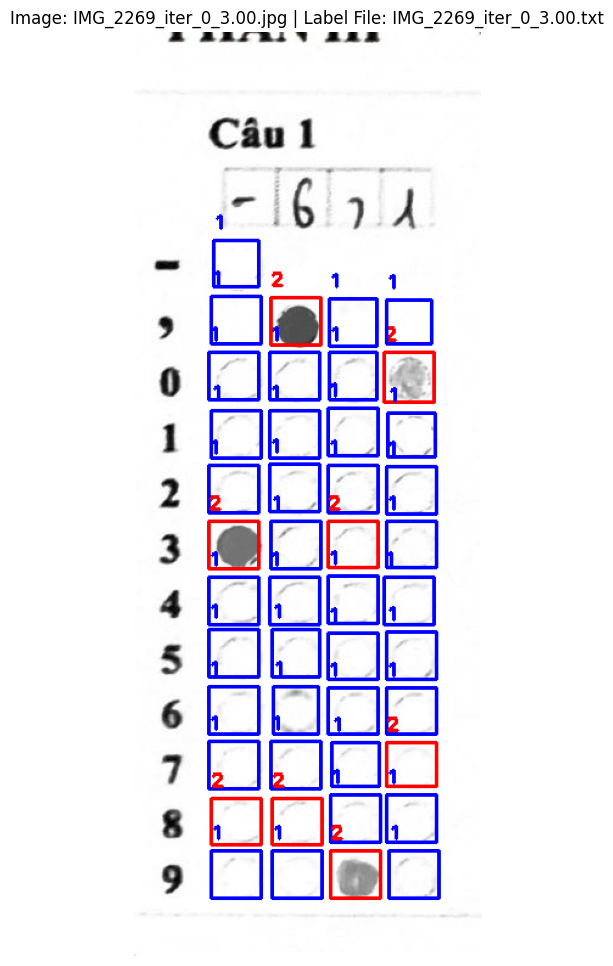

In [37]:
df_45 = newdf[newdf.number_label==45]
# Define directories
cropped_image_dir = "data/cropped_images"         # Directory with original images
output_label_dir = "data/noduplicate_labels"
display_first_entry(df_45, cropped_image_dir, output_label_dir)

In [38]:
import os
import pandas as pd
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

def sort_and_remove_selected_bboxes(label_path, output_label_path):
    """
    Sorts bounding boxes horizontally, sorts a subset vertically, removes the first and last bounding boxes
    from the subset, and saves the remaining bounding boxes.
    
    Steps:
    1. Sort all bounding boxes horizontally (by x_center_norm ascending).
    2. Select bounding boxes from index 1 to 4 (inclusive).
    3. Sort this subset vertically (by y_center_norm ascending).
    4. Remove the first and last bounding boxes from the subset.
    5. Combine the remaining bounding boxes with the untouched ones and save.
    
    Args:
        label_path (str): Path to the original label file.
        output_label_path (str): Path to save the updated label file.
        
    Returns:
        int: Number of bounding boxes retained after processing.
             Returns -1 if the label file is not found.
             Returns 0 if no valid bounding boxes are found.
    """
    try:
        with open(label_path, 'r') as f:
            labels = [line.strip() for line in f if line.strip()]
    except FileNotFoundError:
        print(f"Error: Label file not found: {label_path}")
        return -1  # Indicate failure to process
    
    # Parse labels into a list of tuples (class_id, x_center_norm, y_center_norm, width_norm, height_norm)
    parsed_labels = []
    for label in labels:
        parts = label.split()
        if len(parts) != 5:
            print(f"Skipping malformed label: '{label}' in '{label_path}'")
            continue  # Skip malformed lines
        class_id, x_center_norm, y_center_norm, width_norm, height_norm = parts
        try:
            x_center_norm_float = float(x_center_norm)
            y_center_norm_float = float(y_center_norm)
            parsed_labels.append((class_id, x_center_norm_float, y_center_norm_float, width_norm, height_norm))
        except ValueError:
            print(f"Skipping label with invalid float values: '{label}' in '{label_path}'")
            continue  # Skip labels with invalid float values
    
    if not parsed_labels:
        print(f"No valid bounding boxes found in '{label_path}'.")
        return 0  # Indicate no labels processed
    
    # Step 1: Sort all bounding boxes horizontally (by x_center_norm ascending)
    sorted_horizontally = sorted(parsed_labels, key=lambda x: x[2])
    
    # Step 2: Select bounding boxes from index 1 to 4 (second to fifth)
    if len(sorted_horizontally) < 5:
        print(f"Not enough bounding boxes to perform subset sorting in '{label_path}'. Removing the first bounding box.")
        cleaned_labels = sorted_horizontally[1:]
    else:
        subset = sorted_horizontally[1:5]  # Select bboxes at indices 1,2,3,4
        
        # Step 3: Sort the subset vertically (by y_center_norm ascending)
        sorted_subset_vertically = sorted(subset, key=lambda x: x[1])
        
        # Step 4: Remove the first and last bounding boxes from the subset
        subset_cleaned = sorted_subset_vertically[1:-1]  # Retain bboxes at indices 1 and 2
        
        # Step 5: Combine the remaining bounding boxes with untouched ones
        cleaned_labels = []
        cleaned_labels.extend(sorted_horizontally[:1])      # Bounding boxes before the subset
        cleaned_labels.extend(subset_cleaned)               # Retained subset bounding boxes
        cleaned_labels.extend(sorted_horizontally[5:])      # Bounding boxes after the subset
    
    # Convert back to string format with six decimal places
    cleaned_labels_str = [f"{cls} {float(x):.6f} {float(y):.6f} {float(w):.6f} {float(h):.6f}"
                     for cls, x, y, w, h in cleaned_labels]
    
    # Save the cleaned labels
    with open(output_label_path, 'w') as f:
        for label in cleaned_labels_str:
            f.write(label + '\n')
    
    print(f"Updated label file saved to '{output_label_path}'. Total labels retained: {len(cleaned_labels_str)}")
    return len(cleaned_labels_str)  # Return the number of labels retained

def display_image_with_labels(image_path, label_path):
    """
    Reads an image and its corresponding label file, draws bounding boxes, and displays the image.
    
    Args:
        image_path (str): Path to the image file.
        label_path (str): Path to the label file.
    """
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not read image '{image_path}'.")
        return

    # Read and parse the label file
    try:
        with open(label_path, "r") as f:
            labels = [line.strip() for line in f if line.strip()]
    except FileNotFoundError:
        print(f"Error: Label file '{label_path}' not found.")
        return

    # Get image dimensions
    img_height, img_width = image.shape[:2]

    # Define colors for different class IDs
    COLORS = {
        "0": (0, 255, 0),    # Green
        "1": (255, 0, 0),    # Blue
        "2": (0, 0, 255)     # Red
        # Add more class IDs and colors as needed
    }

    for label in labels:
        parts = label.split()
        if len(parts) != 5:
            print(f"Skipping malformed label: '{label}' in '{label_path}'")
            continue
        class_id, x_center_norm, y_center_norm, width_norm, height_norm = parts

        try:
            # Convert normalized coordinates to absolute pixel values
            x_center = float(x_center_norm) * img_width
            y_center = float(y_center_norm) * img_height
            width = float(width_norm) * img_width
            height = float(height_norm) * img_height

            # Calculate top-left and bottom-right coordinates
            x1 = int(x_center - width / 2)
            y1 = int(y_center - height / 2)
            x2 = int(x1 + width)
            y2 = int(y1 + height)

            # Choose color based on class_id
            color = COLORS.get(class_id, (255, 255, 255))  # Default to white if class_id not defined

            # Draw rectangle
            cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

            # Put class_id text above the bounding box
            cv2.putText(
                image,
                str(int(float(class_id))),
                (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                color,
                2
            )
        except ValueError:
            print(f"Skipping label with invalid float values: '{label}' in '{label_path}'")
            continue

    # Convert BGR image (OpenCV) to RGB (Matplotlib)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image using Matplotlib
    plt.figure(figsize=(12, 12))
    plt.imshow(image_rgb)
    plt.title(os.path.basename(image_path))
    plt.axis('off')
    plt.show()

def process_and_display_first_entry(dfnew, cropped_image_dir, output_label_dir, id=0):
    """
    Processes the specified entry in dfnew by sorting bounding boxes, removing selected ones,
    and displaying the updated image.
    
    Args:
        dfnew (pd.DataFrame): DataFrame containing image and label information.
        cropped_image_dir (str): Directory containing the original images.
        output_label_dir (str): Directory containing the original label files.
        id (int): Index of the entry to process in the DataFrame.
    """
    if dfnew.empty:
        print("The DataFrame 'dfnew' is empty. Exiting function.")
        return

    # Retrieve the specified entry
    entry = dfnew.iloc[id]

    # Extract necessary fields
    image_name = entry['image_name']
    label_name = entry['label_name']

    # Construct full paths
    image_path = os.path.join(cropped_image_dir, image_name)
    original_label_path = os.path.join(output_label_dir, label_name)
    updated_label_path = os.path.join("data/trash", f"updated_{label_name}")

    # Sort bounding boxes, remove selected ones, and save the updated label file
    retained_labels = sort_and_remove_selected_bboxes(
        label_path=original_label_path,
        output_label_path=updated_label_path
    )

    # Update the DataFrame with the new number of labels
    if retained_labels >= 0:
        dfnew.at[dfnew.index[id], 'number_label'] = retained_labels
        dfnew.at[dfnew.index[id], 'standard_number_label'] = retained_labels  # Adjust if needed

    # Display the updated image with remaining bounding boxes
    display_image_with_labels(image_path=image_path, label_path=updated_label_path)


Updated label file saved to 'data/trash\updated_IMG_2269_iter_73_3.00.txt'. Total labels retained: 43


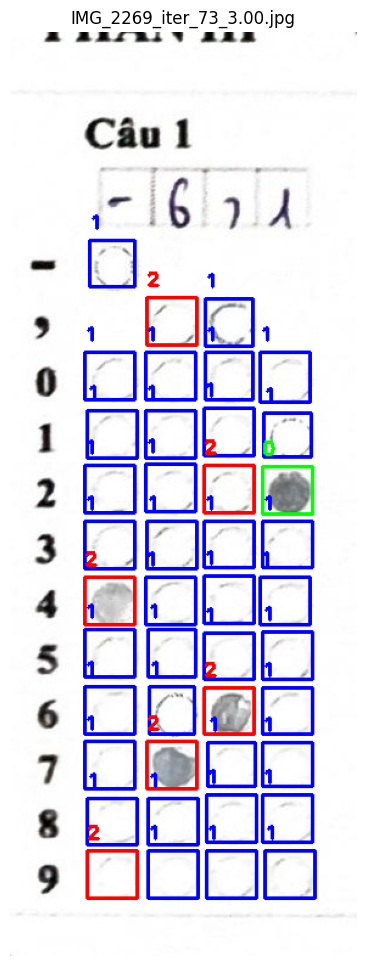

In [39]:
cropped_image_dir = "data/cropped_images"         # Directory with original images
output_label_dir = "data/noduplicate_labels"      # Directory with cleaned label files       
process_and_display_first_entry(df_45, cropped_image_dir=cropped_image_dir, output_label_dir=output_label_dir, id=230)

##### Process

In [40]:
import os
import pandas as pd
from tqdm import tqdm

def sort_and_remove_selected_bboxes(label_path, output_label_path):
    """
    Sorts bounding boxes horizontally, sorts a subset vertically, removes the first and last bounding boxes
    from the subset, and saves the remaining bounding boxes.
    
    Steps:
    1. Sort all bounding boxes horizontally (by x_center_norm ascending).
    2. Select bounding boxes from index 1 to 4 (inclusive).
    3. Sort this subset vertically (by y_center_norm ascending).
    4. Remove the first and last bounding boxes from the subset.
    5. Combine the remaining bounding boxes with untouched ones and save.
    
    Args:
        label_path (str): Path to the original label file.
        output_label_path (str): Path to save the updated label file.
        
    Returns:
        int: Number of bounding boxes retained after processing.
             Returns -1 if the label file is not found.
             Returns 0 if no valid bounding boxes are found.
    """
    try:
        with open(label_path, 'r') as f:
            labels = [line.strip() for line in f if line.strip()]
    except FileNotFoundError:
        print(f"Error: Label file not found: {label_path}")
        return -1  # Indicate failure to process
    
    # Parse labels into a list of tuples (class_id, x_center_norm, y_center_norm, width_norm, height_norm)
    parsed_labels = []
    for label in labels:
        parts = label.split()
        if len(parts) != 5:
            print(f"Skipping malformed label: '{label}' in '{label_path}'")
            continue  # Skip malformed lines
        class_id, x_center_norm, y_center_norm, width_norm, height_norm = parts
        try:
            x_center_norm_float = float(x_center_norm)
            y_center_norm_float = float(y_center_norm)
            width_norm_float = float(width_norm)
            height_norm_float = float(height_norm)
            parsed_labels.append((class_id, x_center_norm_float, y_center_norm_float, width_norm_float, height_norm_float))
        except ValueError:
            print(f"Skipping label with invalid float values: '{label}' in '{label_path}'")
            continue  # Skip labels with invalid float values
    
    if not parsed_labels:
        print(f"No valid bounding boxes found in '{label_path}'.")
        return 0  # Indicate no labels processed
    
    # Step 1: Sort all bounding boxes horizontally (by x_center_norm ascending)
    sorted_horizontally = sorted(parsed_labels, key=lambda x: x[2])
    
    # Step 2: Select bounding boxes from index 1 to 4 (second to fifth)
    if len(sorted_horizontally) < 5:
        print(f"Not enough bounding boxes to perform subset sorting in '{label_path}'. Removing the first bounding box.")
        cleaned_labels = sorted_horizontally[1:]
    else:
        subset = sorted_horizontally[1:5]  # Select bboxes at indices 1,2,3,4
        
        # Step 3: Sort the subset vertically (by y_center_norm ascending)
        sorted_subset_vertically = sorted(subset, key=lambda x: x[1])
        
        # Step 4: Remove the first and last bounding boxes from the subset
        if len(sorted_subset_vertically) >= 2:
            subset_cleaned = sorted_subset_vertically[1:-1]  # Retain bboxes at indices 1 and 2
        else:
            subset_cleaned = []  # If fewer than 2 bounding boxes, remove all
        
        # Step 5: Combine the remaining bounding boxes with untouched ones
        # Remove the original subset from the horizontally sorted list
        remaining_sorted_horizontally = [bbox for idx, bbox in enumerate(sorted_horizontally) if idx < 1 or idx >= 5]
        
        # Add back the cleaned subset
        cleaned_labels = remaining_sorted_horizontally + subset_cleaned
    
    # Convert back to string format with six decimal places
    cleaned_labels_str = [
        f"{cls} {x:.6f} {y:.6f} {w:.6f} {h:.6f}"
        for cls, x, y, w, h in cleaned_labels
    ]
    
    # Save the cleaned labels
    with open(output_label_path, 'w') as f:
        for label in cleaned_labels_str:
            f.write(label + '\n')
    
    print(f"Updated label file saved to '{output_label_path}'. Total labels retained: {len(cleaned_labels_str)}")
    return len(cleaned_labels_str)  # Return the number of labels retained

def process_bulk_labels(df, input_label_dir, output_label_dir):
    """
    Processes all label files listed in the DataFrame by sorting bounding boxes horizontally,
    then sorting a subset vertically, removing specific bounding boxes, and saving the updated labels
    to the output directory.
    
    Args:
        df (pd.DataFrame): DataFrame containing image and label information.
        input_label_dir (str): Directory containing the original label files.
        output_label_dir (str): Directory to save the updated label files.
    
    Returns:
        int: Number of label files successfully processed.
    """
    processed_count = 0
    skipped_count = 0  # To track files that couldn't be processed
    
    for idx, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing Labels"):
        label_name = row['label_name']
        input_label_path = os.path.join(input_label_dir, label_name)
        output_label_path = os.path.join(output_label_dir, label_name)  # Keeping the same file name
    
        retained_labels = sort_and_remove_selected_bboxes(input_label_path, output_label_path)
        if retained_labels > 0:
            # Update the DataFrame with the new number of labels
            df.at[idx, 'number_label'] = retained_labels
            df.at[idx, 'standard_number_label'] = retained_labels  # Adjust if needed
            processed_count += 1
        elif retained_labels == 0:
            print(f"No labels retained after processing '{label_name}'.")
            df.at[idx, 'number_label'] = 0
            df.at[idx, 'standard_number_label'] = 0
            skipped_count += 1
        else:
            print(f"Failed to process label file: {label_name}")
            skipped_count += 1
    
    print(f"\nBulk processing completed. Total files processed: {processed_count}")
    if skipped_count > 0:
        print(f"Total files skipped or failed to process: {skipped_count}")
    
    return processed_count

def update_dataframe_labels(df, output_label_dir):
    """
    Ensures that the DataFrame's 'number_label' and 'standard_number_label' columns are accurately
    updated based on the processed label files.
    
    Args:
        df (pd.DataFrame): DataFrame containing image and label information.
        output_label_dir (str): Directory containing the updated label files.
    """
    for idx, row in tqdm(df.iterrows(), total=df.shape[0], desc="Updating DataFrame Labels"):
        label_name = row['label_name']
        updated_label_path = os.path.join(output_label_dir, label_name)
        
        try:
            with open(updated_label_path, 'r') as f:
                updated_labels = [line.strip() for line in f if line.strip()]
            num_labels = len(updated_labels)
            df.at[idx, 'number_label'] = num_labels
            df.at[idx, 'standard_number_label'] = num_labels  # Adjust if needed
        except FileNotFoundError:
            print(f"Error: Updated label file '{updated_label_path}' not found.")
            df.at[idx, 'number_label'] = 0
            df.at[idx, 'standard_number_label'] = 0

In [41]:
if RERUN:
    # Define directories
    input_label_dir = "data/noduplicate_labels"            # Directory with original label files
    output_label_dir = "data/std_num_bbox_labels"          # Directory to save updated label files
    csv_output_path = "data/df_45_updated.csv"            # Path to save the updated CSV file

    # Create the output directory if it doesn't exist
    if not os.path.exists(output_label_dir):
        os.makedirs(output_label_dir)
        print(f"Created output directory: '{output_label_dir}'")
    else:
        print(f"Output directory already exists: '{output_label_dir}'")

    # Process all label files
    processed_files = process_bulk_labels(df_45, input_label_dir, output_label_dir)
    print(f"\nBulk processing completed. Total files processed: {processed_files}")

    # Save the updated DataFrame to a new CSV
    df_45.to_csv(csv_output_path, index=False)
    print(f"Saved the updated DataFrame to '{csv_output_path}'")

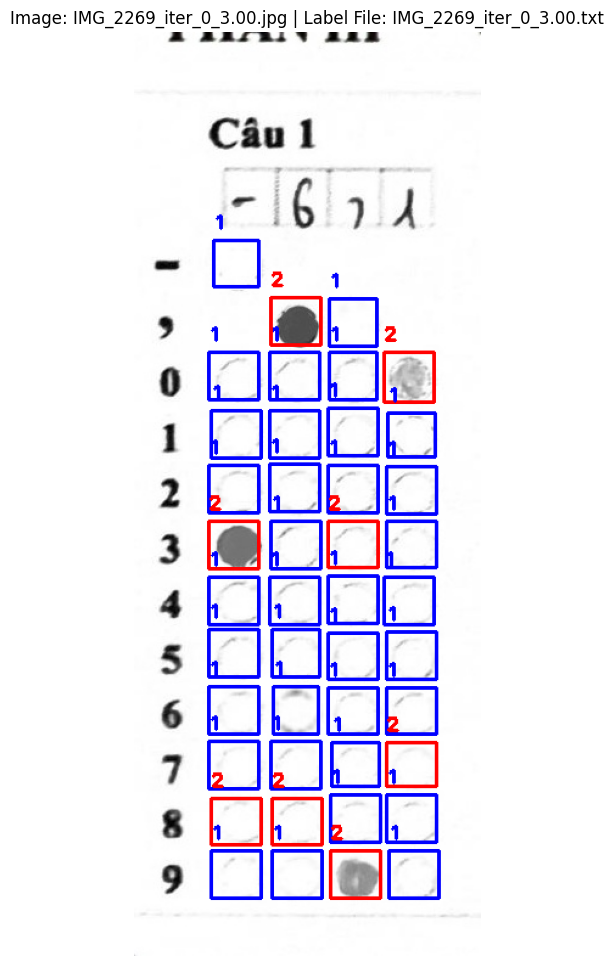

In [42]:
# check with data/std_num_bbox_labels\IMG_2273_iter_9_3.00.txt'

# Load and display the updated label file for the first entry in df_45.

df_45 = pd.read_csv("data/df_45_updated.csv")
df_45.head()

cropped_image_dir = "data/cropped_images"         # Directory with original images
output_label_dir = "data/std_num_bbox_labels"
display_first_entry(df_45, cropped_image_dir, output_label_dir)


#### 44

##### Testing

In [43]:
df_44 = newdf[(newdf.number_label==44) & (newdf.type == "3.00")]

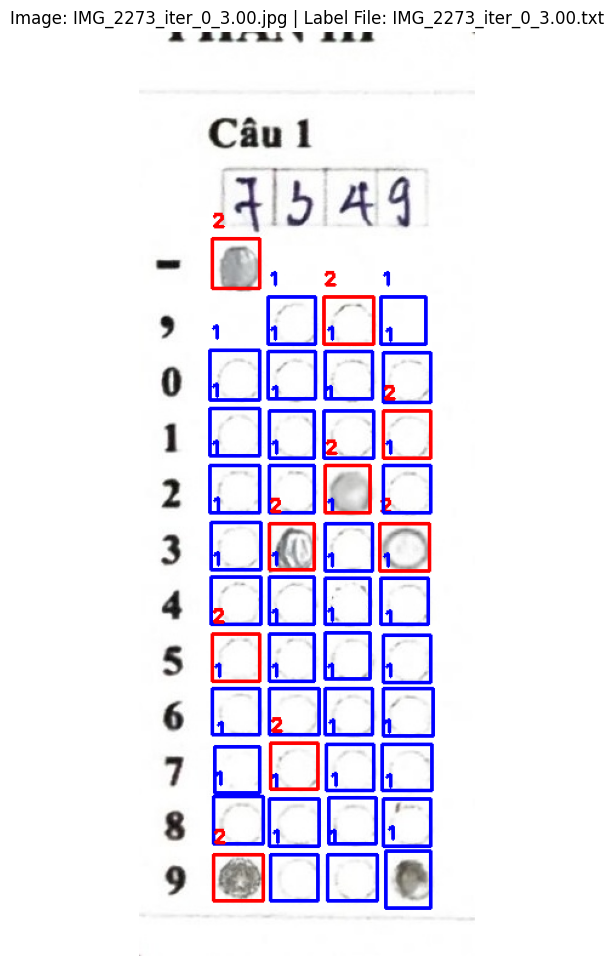

In [44]:
cropped_image_dir = "data/cropped_images"         # Directory with original images
output_label_dir = "data/noduplicate_labels"
display_first_entry(df_44, cropped_image_dir, output_label_dir)

In [45]:
import os
import pandas as pd
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

def sort_and_remove_selected_bboxes(label_path, output_label_path):
    """
    Sorts bounding boxes horizontally, sorts a subset vertically, removes the first and last bounding boxes
    from the subset, and saves the remaining bounding boxes.
    
    Steps:
    1. Sort all bounding boxes horizontally (by x_center_norm ascending).
    2. Select bounding boxes from index 1 to 4 (inclusive).
    3. Sort this subset vertically (by y_center_norm ascending).
    4. Remove the first and last bounding boxes from the subset.
    5. Combine the remaining bounding boxes with the untouched ones and save.
    
    Args:
        label_path (str): Path to the original label file.
        output_label_path (str): Path to save the updated label file.
        
    Returns:
        int: Number of bounding boxes retained after processing.
             Returns -1 if the label file is not found.
             Returns 0 if no valid bounding boxes are found.
    """
    try:
        with open(label_path, 'r') as f:
            labels = [line.strip() for line in f if line.strip()]
    except FileNotFoundError:
        print(f"Error: Label file not found: {label_path}")
        return -1  # Indicate failure to process
    
    # Parse labels into a list of tuples (class_id, x_center_norm, y_center_norm, width_norm, height_norm)
    parsed_labels = []
    for label in labels:
        parts = label.split()
        if len(parts) != 5:
            print(f"Skipping malformed label: '{label}' in '{label_path}'")
            continue  # Skip malformed lines
        class_id, x_center_norm, y_center_norm, width_norm, height_norm = parts
        try:
            x_center_norm_float = float(x_center_norm)
            y_center_norm_float = float(y_center_norm)
            parsed_labels.append((class_id, x_center_norm_float, y_center_norm_float, width_norm, height_norm))
        except ValueError:
            print(f"Skipping label with invalid float values: '{label}' in '{label_path}'")
            continue  # Skip labels with invalid float values
    
    if not parsed_labels:
        print(f"No valid bounding boxes found in '{label_path}'.")
        return 0  # Indicate no labels processed
    
    # Step 1: Sort all bounding boxes horizontally (by x_center_norm ascending)
    sorted_horizontally = sorted(parsed_labels, key=lambda x: x[2])
    
    # Step 2: Select bounding boxes from index 1 to 4 (second to fifth)
    if len(sorted_horizontally) < 5:
        print(f"Not enough bounding boxes to perform subset sorting in '{label_path}'. Removing the first bounding box.")
        cleaned_labels = sorted_horizontally[1:]
    else:
        subset = sorted_horizontally[1:4]  # Select bboxes at indices 1,2,3,4
        
        # Step 3: Sort the subset vertically (by y_center_norm ascending)
        sorted_subset_vertically = sorted(subset, key=lambda x: x[1])
        
        # Step 4: Remove the first and last bounding boxes from the subset
        subset_cleaned = sorted_subset_vertically[:-1]  # Retain bboxes at indices 1 and 2
        
        # Step 5: Combine the remaining bounding boxes with untouched ones
        cleaned_labels = []
        cleaned_labels.extend(sorted_horizontally[:1])      # Bounding boxes before the subset
        cleaned_labels.extend(subset_cleaned)               # Retained subset bounding boxes
        cleaned_labels.extend(sorted_horizontally[4:])      # Bounding boxes after the subset
    
    # Convert back to string format with six decimal places
    cleaned_labels_str = [f"{cls} {float(x):.6f} {float(y):.6f} {float(w):.6f} {float(h):.6f}"
                     for cls, x, y, w, h in cleaned_labels]
    
    # Save the cleaned labels
    with open(output_label_path, 'w') as f:
        for label in cleaned_labels_str:
            f.write(label + '\n')
    
    print(f"Updated label file saved to '{output_label_path}'. Total labels retained: {len(cleaned_labels_str)}")
    return len(cleaned_labels_str)  # Return the number of labels retained

def display_image_with_labels(image_path, label_path):
    """
    Reads an image and its corresponding label file, draws bounding boxes, and displays the image.
    
    Args:
        image_path (str): Path to the image file.
        label_path (str): Path to the label file.
    """
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not read image '{image_path}'.")
        return

    # Read and parse the label file
    try:
        with open(label_path, "r") as f:
            labels = [line.strip() for line in f if line.strip()]
    except FileNotFoundError:
        print(f"Error: Label file '{label_path}' not found.")
        return

    # Get image dimensions
    img_height, img_width = image.shape[:2]

    # Define colors for different class IDs
    COLORS = {
        "0": (0, 255, 0),    # Green
        "1": (255, 0, 0),    # Blue
        "2": (0, 0, 255)     # Red
        # Add more class IDs and colors as needed
    }

    for label in labels:
        parts = label.split()
        if len(parts) != 5:
            print(f"Skipping malformed label: '{label}' in '{label_path}'")
            continue
        class_id, x_center_norm, y_center_norm, width_norm, height_norm = parts

        try:
            # Convert normalized coordinates to absolute pixel values
            x_center = float(x_center_norm) * img_width
            y_center = float(y_center_norm) * img_height
            width = float(width_norm) * img_width
            height = float(height_norm) * img_height

            # Calculate top-left and bottom-right coordinates
            x1 = int(x_center - width / 2)
            y1 = int(y_center - height / 2)
            x2 = int(x1 + width)
            y2 = int(y1 + height)

            # Choose color based on class_id
            color = COLORS.get(class_id, (255, 255, 255))  # Default to white if class_id not defined

            # Draw rectangle
            cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

            # Put class_id text above the bounding box
            cv2.putText(
                image,
                str(int(float(class_id))),
                (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                color,
                2
            )
        except ValueError:
            print(f"Skipping label with invalid float values: '{label}' in '{label_path}'")
            continue

    # Convert BGR image (OpenCV) to RGB (Matplotlib)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image using Matplotlib
    plt.figure(figsize=(12, 12))
    plt.imshow(image_rgb)
    plt.title(os.path.basename(image_path))
    plt.axis('off')
    plt.show()

def process_and_display_first_entry(dfnew, cropped_image_dir, output_label_dir, id=0):
    """
    Processes the specified entry in dfnew by sorting bounding boxes, removing selected ones,
    and displaying the updated image.
    
    Args:
        dfnew (pd.DataFrame): DataFrame containing image and label information.
        cropped_image_dir (str): Directory containing the original images.
        output_label_dir (str): Directory containing the original label files.
        id (int): Index of the entry to process in the DataFrame.
    """
    if dfnew.empty:
        print("The DataFrame 'dfnew' is empty. Exiting function.")
        return

    # Retrieve the specified entry
    entry = dfnew.iloc[id]

    # Extract necessary fields
    image_name = entry['image_name']
    label_name = entry['label_name']

    # Construct full paths
    image_path = os.path.join(cropped_image_dir, image_name)
    original_label_path = os.path.join(output_label_dir, label_name)
    updated_label_path = os.path.join("data/trash", f"updated_{label_name}")

    # Sort bounding boxes, remove selected ones, and save the updated label file
    retained_labels = sort_and_remove_selected_bboxes(
        label_path=original_label_path,
        output_label_path=updated_label_path
    )

    # Update the DataFrame with the new number of labels
    if retained_labels >= 0:
        dfnew.at[dfnew.index[id], 'number_label'] = retained_labels
        dfnew.at[dfnew.index[id], 'standard_number_label'] = retained_labels  # Adjust if needed

    # Display the updated image with remaining bounding boxes
    display_image_with_labels(image_path=image_path, label_path=updated_label_path)


Updated label file saved to 'data/trash\updated_IMG_2273_iter_73_3.00.txt'. Total labels retained: 43


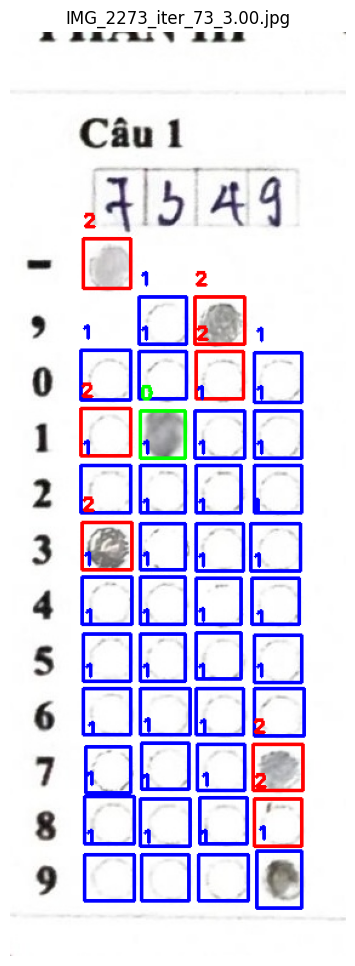

In [46]:
cropped_image_dir = "data/cropped_images"         # Directory with original images
output_label_dir = "data/noduplicate_labels"      # Directory with cleaned label files       
process_and_display_first_entry(df_44, cropped_image_dir=cropped_image_dir, output_label_dir=output_label_dir, id=230)

##### Processing

In [47]:
import os
import pandas as pd
from tqdm import tqdm

def sort_and_remove_selected_bboxes(label_path, output_label_path):
    """
    Sorts bounding boxes horizontally, sorts a subset vertically, removes the first and last bounding boxes
    from the subset, and saves the remaining bounding boxes.
    
    Steps:
    1. Sort all bounding boxes horizontally (by x_center_norm ascending).
    2. Select bounding boxes from index 1 to 4 (inclusive).
    3. Sort this subset vertically (by y_center_norm ascending).
    4. Remove the first and last bounding boxes from the subset.
    5. Combine the remaining bounding boxes with untouched ones and save.
    
    Args:
        label_path (str): Path to the original label file.
        output_label_path (str): Path to save the updated label file.
        
    Returns:
        int: Number of bounding boxes retained after processing.
             Returns -1 if the label file is not found.
             Returns 0 if no valid bounding boxes are found.
    """
    try:
        with open(label_path, 'r') as f:
            labels = [line.strip() for line in f if line.strip()]
    except FileNotFoundError:
        print(f"Error: Label file not found: {label_path}")
        return -1  # Indicate failure to process
    
    # Parse labels into a list of tuples (class_id, x_center_norm, y_center_norm, width_norm, height_norm)
    parsed_labels = []
    for label in labels:
        parts = label.split()
        if len(parts) != 5:
            print(f"Skipping malformed label: '{label}' in '{label_path}'")
            continue  # Skip malformed lines
        class_id, x_center_norm, y_center_norm, width_norm, height_norm = parts
        try:
            x_center_norm_float = float(x_center_norm)
            y_center_norm_float = float(y_center_norm)
            width_norm_float = float(width_norm)
            height_norm_float = float(height_norm)
            parsed_labels.append((class_id, x_center_norm_float, y_center_norm_float, width_norm_float, height_norm_float))
        except ValueError:
            print(f"Skipping label with invalid float values: '{label}' in '{label_path}'")
            continue  # Skip labels with invalid float values
    
    if not parsed_labels:
        print(f"No valid bounding boxes found in '{label_path}'.")
        return 0  # Indicate no labels processed
    
    # Step 1: Sort all bounding boxes horizontally (by x_center_norm ascending)
    sorted_horizontally = sorted(parsed_labels, key=lambda x: x[2])
    
    # Step 2: Select bounding boxes from index 1 to 4 (second to fifth)
    if len(sorted_horizontally) < 5:
        print(f"Not enough bounding boxes to perform subset sorting in '{label_path}'. Removing the first bounding box.")
        cleaned_labels = sorted_horizontally[1:]
    else:
        subset = sorted_horizontally[1:4]  # Select bboxes at indices 1,2,3,4
        
        # Step 3: Sort the subset vertically (by y_center_norm ascending)
        sorted_subset_vertically = sorted(subset, key=lambda x: x[1])
        
        # Step 4: Remove the first and last bounding boxes from the subset
        if len(sorted_subset_vertically) >= 2:
            subset_cleaned = sorted_subset_vertically[:-1]  # Retain bboxes at indices 1 and 2
        else:
            subset_cleaned = []  # If fewer than 2 bounding boxes, remove all
        
        # Step 5: Combine the remaining bounding boxes with untouched ones
        # Remove the original subset from the horizontally sorted list
        remaining_sorted_horizontally = [bbox for idx, bbox in enumerate(sorted_horizontally) if idx < 1 or idx >= 4]
        
        # Add back the cleaned subset
        cleaned_labels = remaining_sorted_horizontally + subset_cleaned
    
    # Convert back to string format with six decimal places
    cleaned_labels_str = [
        f"{cls} {x:.6f} {y:.6f} {w:.6f} {h:.6f}"
        for cls, x, y, w, h in cleaned_labels
    ]
    
    # Save the cleaned labels
    with open(output_label_path, 'w') as f:
        for label in cleaned_labels_str:
            f.write(label + '\n')
    
    print(f"Updated label file saved to '{output_label_path}'. Total labels retained: {len(cleaned_labels_str)}")
    return len(cleaned_labels_str)  # Return the number of labels retained

def process_bulk_labels(df, input_label_dir, output_label_dir):
    """
    Processes all label files listed in the DataFrame by sorting bounding boxes horizontally,
    then sorting a subset vertically, removing specific bounding boxes, and saving the updated labels
    to the output directory.
    
    Args:
        df (pd.DataFrame): DataFrame containing image and label information.
        input_label_dir (str): Directory containing the original label files.
        output_label_dir (str): Directory to save the updated label files.
    
    Returns:
        int: Number of label files successfully processed.
    """
    processed_count = 0
    skipped_count = 0  # To track files that couldn't be processed
    
    for idx, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing Labels"):
        label_name = row['label_name']
        input_label_path = os.path.join(input_label_dir, label_name)
        output_label_path = os.path.join(output_label_dir, label_name)  # Keeping the same file name
    
        retained_labels = sort_and_remove_selected_bboxes(input_label_path, output_label_path)
        if retained_labels > 0:
            # Update the DataFrame with the new number of labels
            df.at[idx, 'number_label'] = retained_labels
            df.at[idx, 'standard_number_label'] = retained_labels  # Adjust if needed
            processed_count += 1
        elif retained_labels == 0:
            print(f"No labels retained after processing '{label_name}'.")
            df.at[idx, 'number_label'] = 0
            df.at[idx, 'standard_number_label'] = 0
            skipped_count += 1
        else:
            print(f"Failed to process label file: {label_name}")
            skipped_count += 1
    
    print(f"\nBulk processing completed. Total files processed: {processed_count}")
    if skipped_count > 0:
        print(f"Total files skipped or failed to process: {skipped_count}")
    
    return processed_count

def update_dataframe_labels(df, output_label_dir):
    """
    Ensures that the DataFrame's 'number_label' and 'standard_number_label' columns are accurately
    updated based on the processed label files.
    
    Args:
        df (pd.DataFrame): DataFrame containing image and label information.
        output_label_dir (str): Directory containing the updated label files.
    """
    for idx, row in tqdm(df.iterrows(), total=df.shape[0], desc="Updating DataFrame Labels"):
        label_name = row['label_name']
        updated_label_path = os.path.join(output_label_dir, label_name)
        
        try:
            with open(updated_label_path, 'r') as f:
                updated_labels = [line.strip() for line in f if line.strip()]
            num_labels = len(updated_labels)
            df.at[idx, 'number_label'] = num_labels
            df.at[idx, 'standard_number_label'] = num_labels  # Adjust if needed
        except FileNotFoundError:
            print(f"Error: Updated label file '{updated_label_path}' not found.")
            df.at[idx, 'number_label'] = 0
            df.at[idx, 'standard_number_label'] = 0

In [48]:
if RERUN:
    # Define directories
    input_label_dir = "data/noduplicate_labels"            # Directory with original label files
    output_label_dir = "data/std_num_bbox_labels"          # Directory to save updated label files
    csv_output_path = "data/df_44_updated.csv"            # Path to save the updated CSV file

    # Create the output directory if it doesn't exist
    if not os.path.exists(output_label_dir):
        os.makedirs(output_label_dir)
        print(f"Created output directory: '{output_label_dir}'")
    else:
        print(f"Output directory already exists: '{output_label_dir}'")

    # Process all label files
    processed_files = process_bulk_labels(df_44, input_label_dir, output_label_dir)
    print(f"\nBulk processing completed. Total files processed: {processed_files}")

    # Save the updated DataFrame to a new CSV
    df_44.to_csv(csv_output_path, index=False)
    print(f"Saved the updated DataFrame to '{csv_output_path}'")

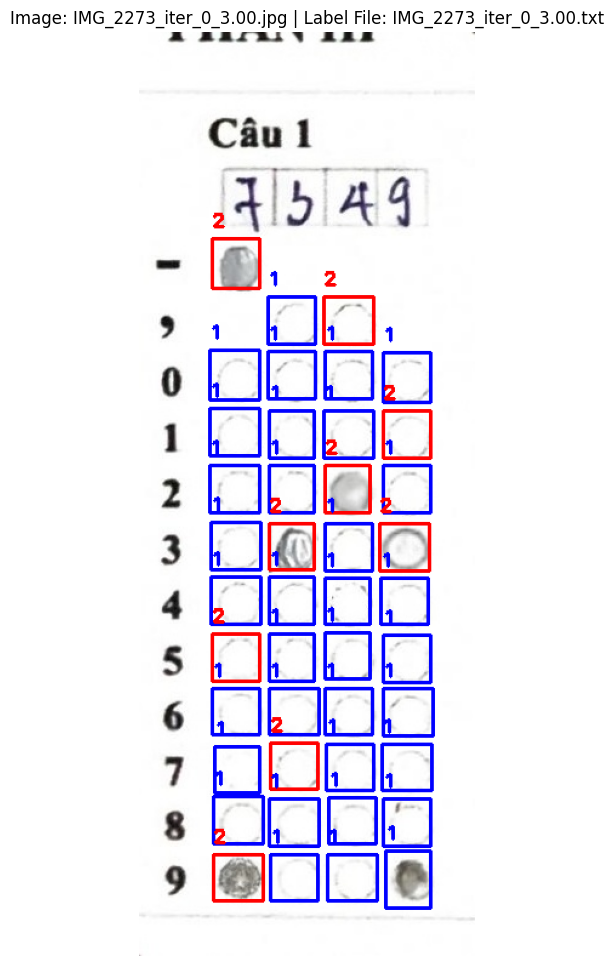

In [49]:
# check with data/std_num_bbox_labels\IMG_2273_iter_9_3.00.txt'

# Load and display the updated label file for the first entry in df_44.

df_44 = pd.read_csv("data/df_44_updated.csv")
df_44.head()

cropped_image_dir = "data/cropped_images"         # Directory with original images
output_label_dir = "data/std_num_bbox_labels"
display_first_entry(df_44, cropped_image_dir, output_label_dir)


#### 3.04

In [50]:
df_304 = newdf[(newdf.type=="3.04")]

In [51]:
df_304.value_counts()

image_name                  org_name               type  label_name                  number_label  num_class_id_2  standard_number_label
IMG_1590_iter_0_3.04.jpg    IMG_1590_iter_0.jpg    3.04  IMG_1590_iter_0_3.04.txt    44            0               43                       1
IMG_1590_iter_247_3.04.jpg  IMG_1590_iter_247.jpg  3.04  IMG_1590_iter_247_3.04.txt  44            0               43                       1
IMG_1590_iter_249_3.04.jpg  IMG_1590_iter_249.jpg  3.04  IMG_1590_iter_249_3.04.txt  44            0               43                       1
IMG_1590_iter_24_3.04.jpg   IMG_1590_iter_24.jpg   3.04  IMG_1590_iter_24_3.04.txt   44            0               43                       1
IMG_1590_iter_250_3.04.jpg  IMG_1590_iter_250.jpg  3.04  IMG_1590_iter_250_3.04.txt  44            0               43                       1
                                                                                                                                           ..
IMG_1590_it

##### test

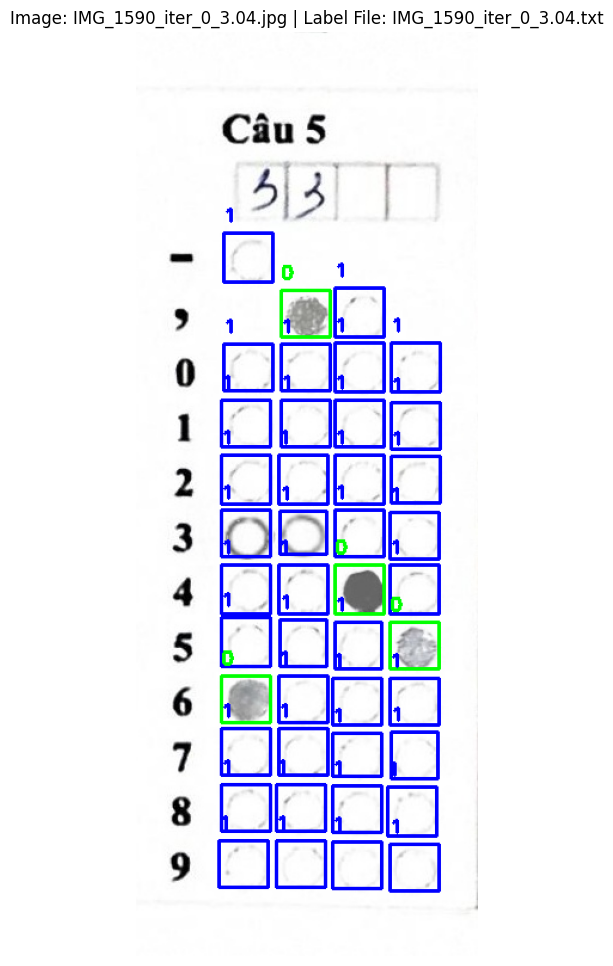

In [52]:
display_first_entry(df_304, cropped_image_dir, output_label_dir)

Updated label file saved to 'data/trash\updated_IMG_1590_iter_73_3.04.txt'. Total labels retained: 43


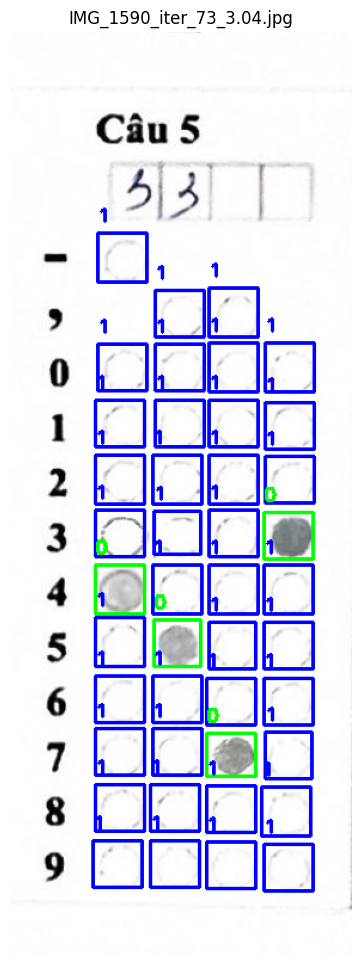

In [53]:
cropped_image_dir = "data/cropped_images"         # Directory with original images
output_label_dir = "data/noduplicate_labels"      # Directory with cleaned label files       
process_and_display_first_entry(df_304, cropped_image_dir=cropped_image_dir, output_label_dir=output_label_dir, id=230)

##### Process

In [54]:
if RERUN:
    # Define directories
    input_label_dir = "data/noduplicate_labels"            # Directory with original label files
    output_label_dir = "data/std_num_bbox_labels"          # Directory to save updated label files
    csv_output_path = "data/df_304_updated.csv"            # Path to save the updated CSV file

    # Create the output directory if it doesn't exist
    if not os.path.exists(output_label_dir):
        os.makedirs(output_label_dir)
        print(f"Created output directory: '{output_label_dir}'")
    else:
        print(f"Output directory already exists: '{output_label_dir}'")

    # Process all label files
    processed_files = process_bulk_labels(df_304, input_label_dir, output_label_dir)
    print(f"\nBulk processing completed. Total files processed: {processed_files}")

    # Save the updated DataFrame to a new CSV
    df_304.to_csv(csv_output_path, index=False)
    print(f"Saved the updated DataFrame to '{csv_output_path}'")

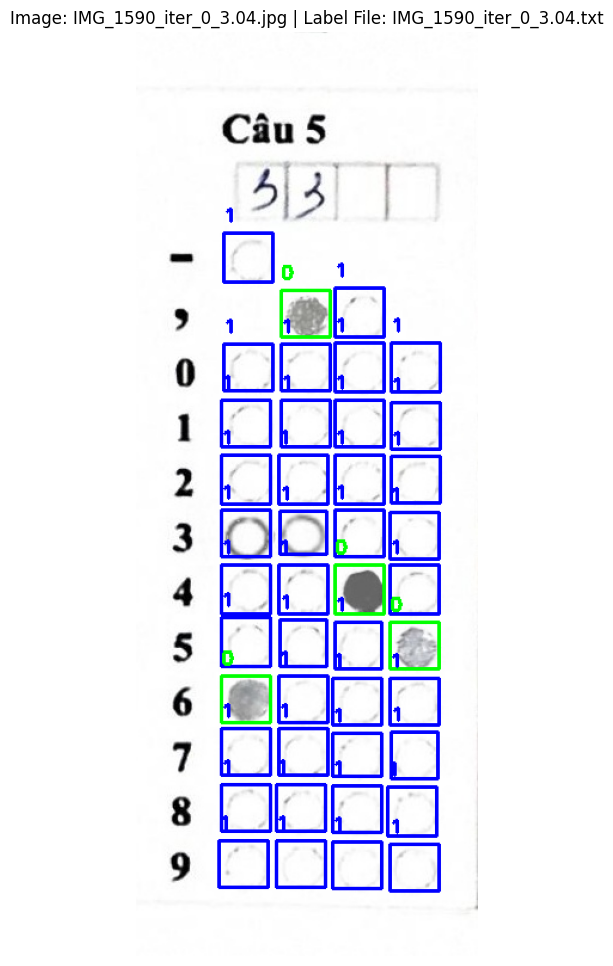

In [55]:
# check with data/std_num_bbox_labels\IMG_2273_iter_9_3.00.txt'

# Load and display the updated label file for the first entry in df_44.

df_304 = pd.read_csv("data/df_304_updated.csv")
df_304.head()

cropped_image_dir = "data/cropped_images"         # Directory with original images
output_label_dir = "data/std_num_bbox_labels"
display_first_entry(df_304, cropped_image_dir, output_label_dir)


#### 3.01

In [56]:
df_301 = newdf[(newdf.type=="3.01")]

In [57]:
df_301.value_counts()

image_name                  org_name               type  label_name                  number_label  num_class_id_2  standard_number_label
IMG_2270_iter_0_3.01.jpg    IMG_2270_iter_0.jpg    3.01  IMG_2270_iter_0_3.01.txt    44            8               43                       1
IMG_2270_iter_247_3.01.jpg  IMG_2270_iter_247.jpg  3.01  IMG_2270_iter_247_3.01.txt  44            7               43                       1
IMG_2270_iter_249_3.01.jpg  IMG_2270_iter_249.jpg  3.01  IMG_2270_iter_249_3.01.txt  44            8               43                       1
IMG_2270_iter_24_3.01.jpg   IMG_2270_iter_24.jpg   3.01  IMG_2270_iter_24_3.01.txt   44            7               43                       1
IMG_2270_iter_250_3.01.jpg  IMG_2270_iter_250.jpg  3.01  IMG_2270_iter_250_3.01.txt  44            9               43                       1
                                                                                                                                           ..
IMG_2270_it

##### Test

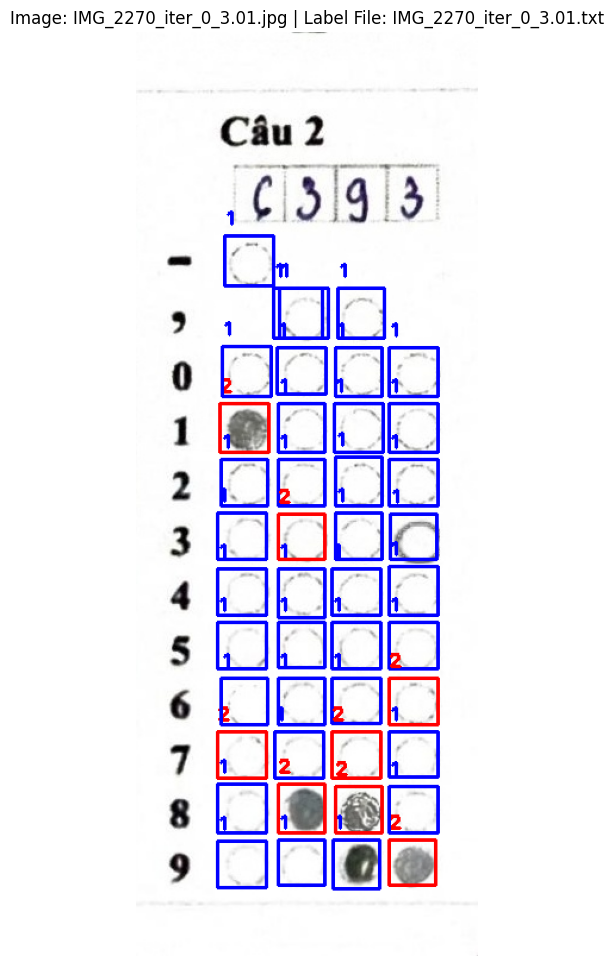

In [58]:
display_first_entry(df_301, cropped_image_dir, output_label_dir)

In [68]:
import os
import pandas as pd
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

def remove_near_duplicates(label_path, output_label_path, iou_threshold=0.9):
    """
    Removes up to two nearly overlapping bounding boxes based on IoU.

    Steps:
    1. Read and parse the label file.
    2. Compute IoU for all pairs of bounding boxes.
    3. Identify duplicates where IoU exceeds the threshold.
    4. Remove one bounding box from each duplicate pair.
    5. Save the updated bounding boxes.

    Args:
        label_path (str): Path to the original label file.
        output_label_path (str): Path to save the updated label file.
        iou_threshold (float): Threshold for IoU to consider bounding boxes as duplicates.

    Returns:
        int: Number of bounding boxes retained after processing.
             Returns -1 if the label file is not found.
             Returns 0 if no valid bounding boxes are found.
    """
    try:
        with open(label_path, 'r') as f:
            labels = [line.strip() for line in f if line.strip()]
    except FileNotFoundError:
        print(f"Error: Label file not found: {label_path}")
        return -1  # Indicate failure to process

    # Parse labels into a list of tuples (class_id, x_center_norm, y_center_norm, width_norm, height_norm)
    parsed_labels = []
    for label in labels:
        parts = label.split()
        if len(parts) != 5:
            print(f"Skipping malformed label: '{label}' in '{label_path}'")
            continue  # Skip malformed lines
        class_id, x_center_norm, y_center_norm, width_norm, height_norm = parts
        try:
            x_center_norm_float = float(x_center_norm)
            y_center_norm_float = float(y_center_norm)
            width_norm_float = float(width_norm)
            height_norm_float = float(height_norm)
            parsed_labels.append((class_id, x_center_norm_float, y_center_norm_float, width_norm_float, height_norm_float))
        except ValueError:
            print(f"Skipping label with invalid float values: '{label}' in '{label_path}'")
            continue  # Skip labels with invalid float values

    if not parsed_labels:
        print(f"No valid bounding boxes found in '{label_path}'.")
        return 0  # Indicate no labels processed

    # Function to compute Intersection over Union (IoU) between two bounding boxes
    def compute_iou(box1, box2):
        """
        Computes IoU between two bounding boxes.

        Args:
            box1 (tuple): (x_center_norm, y_center_norm, width_norm, height_norm)
            box2 (tuple): (x_center_norm, y_center_norm, width_norm, height_norm)

        Returns:
            float: IoU value.
        """
        # Convert normalized coordinates to absolute coordinates assuming image size 1x1 for simplicity
        x1_min = box1[0] - box1[2] / 2
        y1_min = box1[1] - box1[3] / 2
        x1_max = box1[0] + box1[2] / 2
        y1_max = box1[1] + box1[3] / 2

        x2_min = box2[0] - box2[2] / 2
        y2_min = box2[1] - box2[3] / 2
        x2_max = box2[0] + box2[2] / 2
        y2_max = box2[1] + box2[3] / 2

        # Calculate intersection coordinates
        inter_min_x = max(x1_min, x2_min)
        inter_min_y = max(y1_min, y2_min)
        inter_max_x = min(x1_max, x2_max)
        inter_max_y = min(y1_max, y2_max)

        # Compute area of intersection
        inter_width = max(0, inter_max_x - inter_min_x)
        inter_height = max(0, inter_max_y - inter_min_y)
        inter_area = inter_width * inter_height

        # Compute area of both bounding boxes
        box1_area = box1[2] * box1[3]
        box2_area = box2[2] * box2[3]

        # Compute IoU
        union_area = box1_area + box2_area - inter_area
        if union_area == 0:
            return 0
        iou = inter_area / union_area
        return iou

    # Identify duplicates
    to_remove = set()
    for i in range(len(parsed_labels)):
        for j in range(i + 1, len(parsed_labels)):
            if i in to_remove or j in to_remove:
                continue  # Skip already marked boxes
            box1 = parsed_labels[i][1:5]
            box2 = parsed_labels[j][1:5]
            iou = compute_iou(box1, box2)
            if iou > iou_threshold:
                # Mark the second box for removal
                to_remove.add(j)
                # Remove up to two duplicates
                if len(to_remove) >= 2:
                    break
        if len(to_remove) >= 2:
            break

    # Remove duplicates
    cleaned_labels = [bbox for idx, bbox in enumerate(parsed_labels) if idx not in to_remove]

    # Convert back to string format with six decimal places
    cleaned_labels_str = [
        f"{cls} {x:.6f} {y:.6f} {w:.6f} {h:.6f}"
        for cls, x, y, w, h in cleaned_labels
    ]

    # Save the cleaned labels
    with open(output_label_path, 'w') as f:
        for label in cleaned_labels_str:
            f.write(label + '\n')

    print(f"Updated label file saved to '{output_label_path}'. Total labels retained: {len(cleaned_labels_str)}")
    return len(cleaned_labels_str)  # Return the number of labels retained

def display_image_with_labels(image_path, label_path):
    """
    Reads an image and its corresponding label file, draws bounding boxes, and displays the image.
    
    Args:
        image_path (str): Path to the image file.
        label_path (str): Path to the label file.
    """
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not read image '{image_path}'.")
        return

    # Read and parse the label file
    try:
        with open(label_path, "r") as f:
            labels = [line.strip() for line in f if line.strip()]
    except FileNotFoundError:
        print(f"Error: Label file '{label_path}' not found.")
        return

    # Get image dimensions
    img_height, img_width = image.shape[:2]

    # Define colors for different class IDs
    COLORS = {
        "0": (0, 255, 0),    # Green
        "1": (255, 0, 0),    # Blue
        "2": (0, 0, 255)     # Red
        # Add more class IDs and colors as needed
    }

    for label in labels:
        parts = label.split()
        if len(parts) != 5:
            print(f"Skipping malformed label: '{label}' in '{label_path}'")
            continue
        class_id, x_center_norm, y_center_norm, width_norm, height_norm = parts

        try:
            # Convert normalized coordinates to absolute pixel values
            x_center = float(x_center_norm) * img_width
            y_center = float(y_center_norm) * img_height
            width = float(width_norm) * img_width
            height = float(height_norm) * img_height

            # Calculate top-left and bottom-right coordinates
            x1 = int(x_center - width / 2)
            y1 = int(y_center - height / 2)
            x2 = int(x1 + width)
            y2 = int(y1 + height)

            # Choose color based on class_id
            color = COLORS.get(class_id, (255, 255, 255))  # Default to white if class_id not defined

            # Draw rectangle
            cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

            # Put class_id text above the bounding box
            cv2.putText(
                image,
                str(int(float(class_id))),
                (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                color,
                2
            )
        except ValueError:
            print(f"Skipping label with invalid float values: '{label}' in '{label_path}'")
            continue

    # Convert BGR image (OpenCV) to RGB (Matplotlib)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image using Matplotlib
    plt.figure(figsize=(12, 12))
    plt.imshow(image_rgb)
    plt.title(os.path.basename(image_path))
    plt.axis('off')
    plt.show()

def process_and_display_first_entry(dfnew, cropped_image_dir, output_label_dir, id=0):
    """
    Processes the specified entry in dfnew by removing near-duplicate bounding boxes and displaying the updated image.
    
    Args:
        dfnew (pd.DataFrame): DataFrame containing image and label information.
        cropped_image_dir (str): Directory containing the original images.
        output_label_dir (str): Directory containing the original label files.
        id (int): Index of the entry to process in the DataFrame.
    """
    if dfnew.empty:
        print("The DataFrame 'dfnew' is empty. Exiting function.")
        return

    # Retrieve the specified entry
    entry = dfnew.iloc[id]

    # Extract necessary fields
    image_name = entry['image_name']
    label_name = entry['label_name']

    # Construct full paths
    image_path = os.path.join(cropped_image_dir, image_name)
    original_label_path = os.path.join(output_label_dir, label_name)
    updated_label_path = os.path.join("data/trash", f"updated_{label_name}")

    # Ensure the trash directory exists
    os.makedirs("data/trash", exist_ok=True)

    # Remove near duplicates and save the updated label file
    retained_labels = remove_near_duplicates(
        label_path=original_label_path,
        output_label_path=updated_label_path,
        iou_threshold=0.5  # Adjust the threshold as needed
    )

    # Update the DataFrame with the new number of labels
    if retained_labels >= 0:
        dfnew.at[dfnew.index[id], 'number_label'] = retained_labels
        dfnew.at[dfnew.index[id], 'standard_number_label'] = retained_labels  # Adjust if needed

    # Display the updated image with remaining bounding boxes
    display_image_with_labels(image_path=image_path, label_path=updated_label_path)


Updated label file saved to 'data/trash\updated_IMG_2270_iter_73_3.01.txt'. Total labels retained: 43


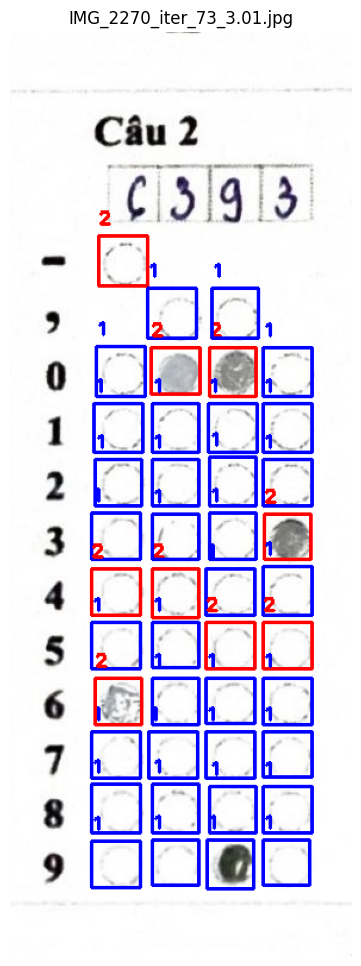

In [69]:
cropped_image_dir = "data/cropped_images"         # Directory with original images
output_label_dir = "data/noduplicate_labels"
process_and_display_first_entry(df_301,cropped_image_dir, output_label_dir, id=230)

##### Process

In [70]:
import os
import pandas as pd
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

def remove_near_duplicates(label_path, output_label_path, iou_threshold=0.5):
    """
    Removes up to two nearly overlapping bounding boxes based on IoU.

    Steps:
    1. Read and parse the label file.
    2. Compute IoU for all pairs of bounding boxes.
    3. Identify duplicates where IoU exceeds the threshold.
    4. Remove one bounding box from each duplicate pair.
    5. Save the updated bounding boxes.

    Args:
        label_path (str): Path to the original label file.
        output_label_path (str): Path to save the updated label file.
        iou_threshold (float): Threshold for IoU to consider bounding boxes as duplicates.

    Returns:
        int: Number of bounding boxes retained after processing.
             Returns -1 if the label file is not found.
             Returns 0 if no valid bounding boxes are found.
    """
    try:
        with open(label_path, 'r') as f:
            labels = [line.strip() for line in f if line.strip()]
    except FileNotFoundError:
        print(f"Error: Label file not found: {label_path}")
        return -1  # Indicate failure to process

    # Parse labels into a list of tuples (class_id, x_center_norm, y_center_norm, width_norm, height_norm)
    parsed_labels = []
    for label in labels:
        parts = label.split()
        if len(parts) != 5:
            print(f"Skipping malformed label: '{label}' in '{label_path}'")
            continue  # Skip malformed lines
        class_id, x_center_norm, y_center_norm, width_norm, height_norm = parts
        try:
            x_center_norm_float = float(x_center_norm)
            y_center_norm_float = float(y_center_norm)
            width_norm_float = float(width_norm)
            height_norm_float = float(height_norm)
            parsed_labels.append((class_id, x_center_norm_float, y_center_norm_float, width_norm_float, height_norm_float))
        except ValueError:
            print(f"Skipping label with invalid float values: '{label}' in '{label_path}'")
            continue  # Skip labels with invalid float values

    if not parsed_labels:
        print(f"No valid bounding boxes found in '{label_path}'.")
        return 0  # Indicate no labels processed

    # Function to compute Intersection over Union (IoU) between two bounding boxes
    def compute_iou(box1, box2):
        """
        Computes IoU between two bounding boxes.

        Args:
            box1 (tuple): (x_center_norm, y_center_norm, width_norm, height_norm)
            box2 (tuple): (x_center_norm, y_center_norm, width_norm, height_norm)

        Returns:
            float: IoU value.
        """
        # Convert normalized coordinates to absolute coordinates assuming image size 1x1 for simplicity
        x1_min = box1[0] - box1[2] / 2
        y1_min = box1[1] - box1[3] / 2
        x1_max = box1[0] + box1[2] / 2
        y1_max = box1[1] + box1[3] / 2

        x2_min = box2[0] - box2[2] / 2
        y2_min = box2[1] - box2[3] / 2
        x2_max = box2[0] + box2[2] / 2
        y2_max = box2[1] + box2[3] / 2

        # Calculate intersection coordinates
        inter_min_x = max(x1_min, x2_min)
        inter_min_y = max(y1_min, y2_min)
        inter_max_x = min(x1_max, x2_max)
        inter_max_y = min(y1_max, y2_max)

        # Compute area of intersection
        inter_width = max(0, inter_max_x - inter_min_x)
        inter_height = max(0, inter_max_y - inter_min_y)
        inter_area = inter_width * inter_height

        # Compute area of both bounding boxes
        box1_area = box1[2] * box1[3]
        box2_area = box2[2] * box2[3]

        # Compute IoU
        union_area = box1_area + box2_area - inter_area
        if union_area == 0:
            return 0
        iou = inter_area / union_area
        return iou

    # Identify duplicates
    to_remove = set()
    for i in range(len(parsed_labels)):
        for j in range(i + 1, len(parsed_labels)):
            if i in to_remove or j in to_remove:
                continue  # Skip already marked boxes
            box1 = parsed_labels[i][1:5]
            box2 = parsed_labels[j][1:5]
            iou = compute_iou(box1, box2)
            if iou > iou_threshold:
                # Mark the second box for removal
                to_remove.add(j)
                # Remove up to two duplicates
                if len(to_remove) >= 2:
                    break
        if len(to_remove) >= 2:
            break

    # Remove duplicates
    cleaned_labels = [bbox for idx, bbox in enumerate(parsed_labels) if idx not in to_remove]

    # Convert back to string format with six decimal places
    cleaned_labels_str = [
        f"{cls} {x:.6f} {y:.6f} {w:.6f} {h:.6f}"
        for cls, x, y, w, h in cleaned_labels
    ]

    # Save the cleaned labels
    with open(output_label_path, 'w') as f:
        for label in cleaned_labels_str:
            f.write(label + '\n')

    print(f"Updated label file saved to '{output_label_path}'. Total labels retained: {len(cleaned_labels_str)}")
    return len(cleaned_labels_str)  # Return the number of labels retained

def process_bulk_labels(df, input_label_dir, output_label_dir, iou_threshold=0.5):
    """
    Processes all label files listed in the DataFrame by removing near-duplicate bounding boxes
    based on IoU threshold and saving the updated labels to the output directory.

    Args:
        df (pd.DataFrame): DataFrame containing image and label information.
        input_label_dir (str): Directory containing the original label files.
        output_label_dir (str): Directory to save the updated label files.
        iou_threshold (float): Threshold for IoU to consider bounding boxes as duplicates.

    Returns:
        int: Number of label files successfully processed.
    """
    processed_count = 0
    skipped_count = 0  # To track files that couldn't be processed

    # Ensure the output directory exists
    os.makedirs(output_label_dir, exist_ok=True)

    for idx, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing Labels"):
        label_name = row['label_name']
        input_label_path = os.path.join(input_label_dir, label_name)
        output_label_path = os.path.join(output_label_dir, label_name)  # Keeping the same file name

        retained_labels = remove_near_duplicates(input_label_path, output_label_path, iou_threshold=iou_threshold)
        if retained_labels > 0:
            # Update the DataFrame with the new number of labels
            df.at[idx, 'number_label'] = retained_labels
            df.at[idx, 'standard_number_label'] = retained_labels  # Adjust if needed
            processed_count += 1
        elif retained_labels == 0:
            print(f"No labels retained after processing '{label_name}'.")
            df.at[idx, 'number_label'] = 0
            df.at[idx, 'standard_number_label'] = 0
            skipped_count += 1
        else:
            print(f"Failed to process label file: {label_name}")
            skipped_count += 1

    print(f"\nBulk processing completed. Total files processed: {processed_count}")
    if skipped_count > 0:
        print(f"Total files skipped or failed to process: {skipped_count}")

    return processed_count

In [65]:
if True:
    # Define directories
    input_label_dir = "data/noduplicate_labels"            # Directory with original label files
    output_label_dir = "data/std_num_bbox_labels"          # Directory to save updated label files
    csv_output_path = "data/df_301_updated.csv"            # Path to save the updated CSV file

    # Create the output directory if it doesn't exist
    if not os.path.exists(output_label_dir):
        os.makedirs(output_label_dir)
        print(f"Created output directory: '{output_label_dir}'")
    else:
        print(f"Output directory already exists: '{output_label_dir}'")

    # Process all label files
    processed_files = process_bulk_labels(df_301, input_label_dir, output_label_dir)
    print(f"\nBulk processing completed. Total files processed: {processed_files}")

    # Save the updated DataFrame to a new CSV
    df_301.to_csv(csv_output_path, index=False)
    print(f"Saved the updated DataFrame to '{csv_output_path}'")

Output directory already exists: 'data/std_num_bbox_labels'


Processing Labels:   1%|          | 3/260 [00:00<00:09, 26.49it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_0_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_100_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_101_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_102_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_103_3.01.txt'. Total labels retained: 43


Processing Labels:   3%|▎         | 7/260 [00:00<00:07, 33.01it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_104_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_105_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_106_3.01.txt'. Total labels retained: 43


Processing Labels:   4%|▍         | 11/260 [00:00<00:07, 34.33it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_107_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_108_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_109_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_10_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_110_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_111_3.01.txt'. Total labels retained: 43


Processing Labels:   6%|▌         | 16/260 [00:00<00:06, 36.55it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_112_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_113_3.01.txt'. Total labels retained: 43


Processing Labels:   8%|▊         | 20/260 [00:00<00:07, 33.21it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_114_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_115_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_116_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_117_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_118_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_119_3.01.txt'. Total labels retained: 43


Processing Labels:   9%|▉         | 24/260 [00:00<00:07, 32.49it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_11_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_120_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_121_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_122_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_123_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_124_3.01.txt'. Total labels retained: 43


Processing Labels:  12%|█▏        | 32/260 [00:00<00:07, 32.30it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_125_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_126_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_127_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_128_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_129_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_12_3.01.txt'. Total labels retained: 43


Processing Labels:  15%|█▌        | 40/260 [00:01<00:07, 30.54it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_130_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_131_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_132_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_133_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_134_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_135_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_136_3.01.txt'. Total labels retained: 43


Processing Labels:  18%|█▊        | 48/260 [00:01<00:06, 32.67it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_137_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_138_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_139_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_13_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_140_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_141_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_142_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_143_3.01.txt'. Total labels retained: 43


Processing Labels:  22%|██▏       | 56/260 [00:01<00:06, 33.75it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_144_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_145_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_146_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_147_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_148_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_149_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_14_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_150_3.01.txt'. Total labels retained: 43


Processing Labels:  25%|██▌       | 65/260 [00:01<00:05, 36.82it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_151_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_152_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_153_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_154_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_155_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_156_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_157_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_158_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_159_3.01.txt'. Total labels retained: 43


Processing Labels:  29%|██▉       | 75/260 [00:02<00:04, 40.84it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_15_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_160_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_161_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_162_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_163_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_164_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_165_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_166_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_167_3.01.txt'. Total labels retained: 43
Updated label file s

Processing Labels:  33%|███▎      | 85/260 [00:02<00:04, 42.32it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_169_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_16_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_170_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_171_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_172_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_173_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_174_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_175_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_176_3.01.txt'. Total labels retained: 43


Processing Labels:  37%|███▋      | 95/260 [00:02<00:03, 43.14it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_177_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_178_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_179_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_17_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_180_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_181_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_182_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_183_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_184_3.01.txt'. Total labels retained: 43
Updated label file s

Processing Labels:  38%|███▊      | 100/260 [00:02<00:03, 42.82it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_186_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_187_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_188_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_189_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_18_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_190_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_191_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_192_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_193_3.01.txt'. Total labels retained: 43


Processing Labels:  42%|████▏     | 110/260 [00:02<00:03, 44.06it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_194_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_195_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_196_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_197_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_198_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_199_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_19_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_1_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_200_3.01.txt'. Total labels retained: 43
Updated label file sav

Processing Labels:  46%|████▌     | 120/260 [00:03<00:03, 45.47it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_202_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_203_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_204_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_205_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_206_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_207_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_208_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_209_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_20_3.01.txt'. Total labels retained: 43
Updated label file s

Processing Labels:  50%|█████     | 130/260 [00:03<00:02, 43.66it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_211_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_212_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_213_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_214_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_215_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_216_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_217_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_218_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_219_3.01.txt'. Total labels retained: 43
Updated label file 

Processing Labels:  54%|█████▍    | 140/260 [00:03<00:02, 44.16it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_220_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_221_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_222_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_223_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_224_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_225_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_226_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_227_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_228_3.01.txt'. Total labels retained: 43
Updated label file 

Processing Labels:  58%|█████▊    | 150/260 [00:03<00:02, 41.31it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_22_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_230_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_231_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_232_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_233_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_234_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_235_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_236_3.01.txt'. Total labels retained: 43


Processing Labels:  62%|██████▏   | 160/260 [00:04<00:02, 40.69it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_237_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_238_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_239_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_23_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_240_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_241_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_242_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_243_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_244_3.01.txt'. Total labels retained: 43


Processing Labels:  63%|██████▎   | 165/260 [00:04<00:02, 42.62it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_245_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_246_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_247_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_248_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_249_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_24_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_250_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_251_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_252_3.01.txt'. Total labels retained: 43


Processing Labels:  67%|██████▋   | 175/260 [00:04<00:01, 42.99it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_253_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_254_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_255_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_256_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_257_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_258_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_259_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_25_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_26_3.01.txt'. Total labels retained: 43


Processing Labels:  71%|███████   | 185/260 [00:04<00:01, 42.30it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_27_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_28_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_29_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_2_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_30_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_31_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_32_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_33_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_34_3.01.txt'. Total labels retained: 43


Processing Labels:  75%|███████▌  | 195/260 [00:04<00:01, 41.40it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_35_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_36_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_37_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_38_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_39_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_3_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_40_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_41_3.01.txt'. Total labels retained: 43


Processing Labels:  79%|███████▉  | 205/260 [00:05<00:01, 41.17it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_42_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_43_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_44_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_45_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_46_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_47_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_48_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_49_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_4_3.01.txt'. Total labels retained: 43


Processing Labels:  81%|████████  | 210/260 [00:05<00:01, 41.45it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_50_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_51_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_52_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_53_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_54_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_55_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_56_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_57_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_58_3.01.txt'. Total labels retained: 43


Processing Labels:  85%|████████▍ | 220/260 [00:05<00:01, 38.94it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_59_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_5_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_60_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_61_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_62_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_63_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_64_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_65_3.01.txt'. Total labels retained: 43


Processing Labels:  88%|████████▊ | 229/260 [00:05<00:00, 40.31it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_66_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_67_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_68_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_69_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_6_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_70_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_71_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_72_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_73_3.01.txt'. Total labels retained: 43
Updated label file saved to '

Processing Labels:  92%|█████████▏| 239/260 [00:06<00:00, 42.14it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_75_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_76_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_77_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_78_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_79_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_7_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_80_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_81_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_82_3.01.txt'. Total labels retained: 43


Processing Labels:  96%|█████████▌| 249/260 [00:06<00:00, 41.67it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_83_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_84_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_85_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_86_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_87_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_88_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_89_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_8_3.01.txt'. Total labels retained: 43


Processing Labels:  98%|█████████▊| 254/260 [00:06<00:00, 40.35it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_90_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_91_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_92_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_93_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_94_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_95_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_96_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_97_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_98_3.01.txt'. Total labels retained: 43


Processing Labels: 100%|██████████| 260/260 [00:06<00:00, 39.58it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_99_3.01.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_2270_iter_9_3.01.txt'. Total labels retained: 43

Bulk processing completed. Total files processed: 260

Bulk processing completed. Total files processed: 260
Saved the updated DataFrame to 'data/df_301_updated.csv'


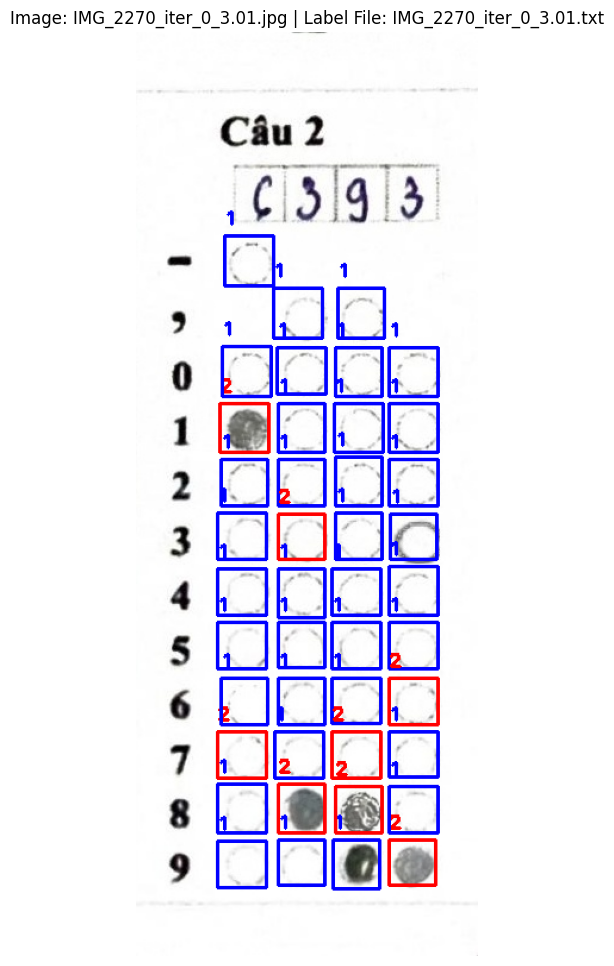

In [74]:
# check with data/std_num_bbox_labels\IMG_2273_iter_9_3.00.txt'

# Load and display the updated label file for the first entry in df_44.

df_301 = pd.read_csv("data/df_301_updated.csv")
df_301.head()

cropped_image_dir = "data/cropped_images"         # Directory with original images
output_label_dir = "data/std_num_bbox_labels"
display_first_entry(df_301, cropped_image_dir, output_label_dir,id=0)


### Missing

In [77]:
new_df = df[df["standard_number_label"] > df["number_label"]]

In [78]:
new_df

image_name               org_name  type  \
12      IMG_1581_iter_0_3.04.jpg    IMG_1581_iter_0.jpg  3.04   
28    IMG_1581_iter_100_3.04.jpg  IMG_1581_iter_100.jpg  3.04   
44    IMG_1581_iter_101_3.04.jpg  IMG_1581_iter_101.jpg  3.04   
60    IMG_1581_iter_102_3.04.jpg  IMG_1581_iter_102.jpg  3.04   
76    IMG_1581_iter_103_3.04.jpg  IMG_1581_iter_103.jpg  3.04   
...                          ...                    ...   ...   
4092   IMG_1581_iter_96_3.04.jpg   IMG_1581_iter_96.jpg  3.04   
4108   IMG_1581_iter_97_3.04.jpg   IMG_1581_iter_97.jpg  3.04   
4124   IMG_1581_iter_98_3.04.jpg   IMG_1581_iter_98.jpg  3.04   
4140   IMG_1581_iter_99_3.04.jpg   IMG_1581_iter_99.jpg  3.04   
4156    IMG_1581_iter_9_3.04.jpg    IMG_1581_iter_9.jpg  3.04   

                      label_name  number_label  num_class_id_2  \
12      IMG_1581_iter_0_3.04.txt            42               0   
28    IMG_1581_iter_100_3.04.txt            42               0   
44    IMG_1581_iter_101_3.04.txt            42               0   
60    IMG_1581_iter_102_3.04.txt            42               0   
76    IMG_1581_iter_103_3.04.txt            42               0   
...                          ...           ...             ...   
4092   IMG_1581_iter_96_3.04.txt            42               0   
4108   IMG_1581_iter_97_3.04.txt            42               0   
4124   IMG_1581_iter_98_3.04.txt            42               0   
4140   IMG_1581_iter_99_3.04.txt            42               0   
4156    IMG_1581_iter_9_3.04.txt            42               0   

      standard_number_label  
12                       43  
28                       43  
44                       43  
60                       43  
76                       43  
...                     ...  
4092                     43  
4108                     43  
4124                     43  
4140                     43  
4156                     43  

[260 rows x 7 columns]

#### Testing

In [80]:
missing_df = new_df.copy()

In [92]:
missing_df.head()

image_name               org_name  type  \
12    IMG_1581_iter_0_3.04.jpg    IMG_1581_iter_0.jpg  3.04   
28  IMG_1581_iter_100_3.04.jpg  IMG_1581_iter_100.jpg  3.04   
44  IMG_1581_iter_101_3.04.jpg  IMG_1581_iter_101.jpg  3.04   
60  IMG_1581_iter_102_3.04.jpg  IMG_1581_iter_102.jpg  3.04   
76  IMG_1581_iter_103_3.04.jpg  IMG_1581_iter_103.jpg  3.04   

                    label_name  number_label  num_class_id_2  \
12    IMG_1581_iter_0_3.04.txt            42               0   
28  IMG_1581_iter_100_3.04.txt            42               0   
44  IMG_1581_iter_101_3.04.txt            42               0   
60  IMG_1581_iter_102_3.04.txt            42               0   
76  IMG_1581_iter_103_3.04.txt            42               0   

    standard_number_label  
12                     43  
28                     43  
44                     43  
60                     43  
76                     43

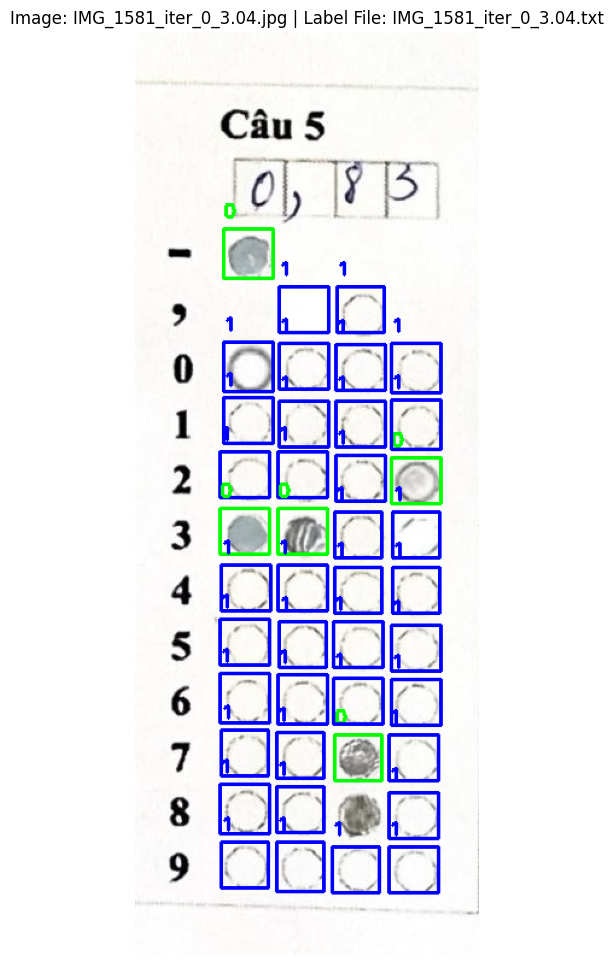

In [81]:
cropped_image_dir = "data/cropped_images"         # Directory with original images
output_label_dir = "data/noduplicate_labels"
display_first_entry(missing_df, cropped_image_dir, output_label_dir)

In [102]:
import os

def sort_and_merge_selected_bboxes(label_path, output_label_path):
    """
    Sorts bounding boxes vertically, selects a subset, sorts the subset horizontally,
    merges the second and third bounding boxes in the sorted subset by averaging their coordinates and sizes,
    adds the merged bounding box with class_id=2 to the list without replacing any existing ones,
    and saves the updated bounding boxes.
    
    Steps:
    1. Sort all bounding boxes vertically (by y_center_norm ascending).
    2. Select bounding boxes from index -7 to -5 (inclusive) as a subset.
    3. Sort this subset horizontally (by x_center_norm ascending).
    4. Merge the second and third bounding boxes in the sorted subset by averaging their coordinates and sizes.
    5. Add the merged bounding box with class_id=2 to the list without replacing any existing ones.
    6. Save the updated bounding boxes.
    
    Args:
        label_path (str): Path to the original label file.
        output_label_path (str): Path to save the updated label file.
        
    Returns:
        int: Number of bounding boxes retained after processing.
             Returns -1 if the label file is not found.
             Returns 0 if no valid bounding boxes are found.
    """
    try:
        with open(label_path, 'r') as f:
            labels = [line.strip() for line in f if line.strip()]
    except FileNotFoundError:
        print(f"Error: Label file not found: {label_path}")
        return -1  # Indicate failure to process
    
    # Parse labels into a list of tuples (class_id, x_center_norm, y_center_norm, width_norm, height_norm)
    parsed_labels = []
    for label in labels:
        parts = label.split()
        if len(parts) != 5:
            print(f"Skipping malformed label: '{label}' in '{label_path}'")
            continue  # Skip malformed lines
        class_id, x_center_norm, y_center_norm, width_norm, height_norm = parts
        try:
            x_center_norm_float = float(x_center_norm)
            y_center_norm_float = float(y_center_norm)
            width_norm_float = float(width_norm)
            height_norm_float = float(height_norm)
            parsed_labels.append((class_id, x_center_norm_float, y_center_norm_float, width_norm_float, height_norm_float))
        except ValueError:
            print(f"Skipping label with invalid float values: '{label}' in '{label_path}'")
            continue  # Skip labels with invalid float values
    
    if not parsed_labels:
        print(f"No valid bounding boxes found in '{label_path}'.")
        return 0  # Indicate no labels processed
    
    # Step 1: Sort all bounding boxes vertically (by y_center_norm ascending)
    sorted_vertically = sorted(parsed_labels, key=lambda x: x[2])
    
    # Step 2: Select bounding boxes from index -7 to -5 (inclusive) as a subset
    if len(sorted_vertically) < 5:
        print(f"Not enough bounding boxes to perform subset selection in '{label_path}'. No merging performed.")
        cleaned_labels = sorted_vertically  # No changes
    else:
        # Determine subset indices
        subset_start = max(len(sorted_vertically) - 7, 0)
        subset_end = max(len(sorted_vertically) - 4, 0)  # Exclusive in slicing
        
        subset = sorted_vertically[subset_start:subset_end]  # This will get up to 3 boxes: indices -7, -6, -5
        
        # Step 3: Sort this subset horizontally (by x_center_norm ascending)
        sorted_subset_horizontally = sorted(subset, key=lambda x: x[1])
        
        # Step 4: Merge the second and third bounding boxes in the sorted subset
        if len(sorted_subset_horizontally) < 3:
            print(f"Not enough bounding boxes in the subset to perform merging in '{label_path}'. No merging performed.")
            merged_box = None
        else:
            box1 = sorted_subset_horizontally[1]
            box2 = sorted_subset_horizontally[2]
            
            # Compute the mean of the second and third boxes
            merged_class_id = "2"  # Set class_id to 2 for the merged box
            merged_x_center_norm = (box1[1] + box2[1]) / 2
            merged_y_center_norm = (box1[2] + box2[2]) / 2
            merged_width_norm = (box1[3] + box2[3]) / 2
            merged_height_norm = (box1[4] + box2[4]) / 2
            
            merged_box = (merged_class_id, merged_x_center_norm, merged_y_center_norm, merged_width_norm, merged_height_norm)
        
        # Step 5: Add the merged bounding box to the list without replacing
        if merged_box:
            cleaned_labels = sorted_vertically + [merged_box]
        else:
            cleaned_labels = sorted_vertically  # No changes
    
    # Convert back to string format with six decimal places
    cleaned_labels_str = [
        f"{cls} {x:.6f} {y:.6f} {w:.6f} {h:.6f}"
        for cls, x, y, w, h in cleaned_labels
    ]
    
    # Save the cleaned labels
    with open(output_label_path, 'w') as f:
        for label in cleaned_labels_str:
            f.write(label + '\n')
    
    print(f"Updated label file saved to '{output_label_path}'. Total labels retained: {len(cleaned_labels_str)}")
    return len(cleaned_labels_str)  # Return the number of labels retained

In [95]:
def process_and_display_first_entry(dfnew, cropped_image_dir, output_label_dir, id=0):
    """
    Processes the specified entry in dfnew by sorting bounding boxes vertically,
    selecting and sorting a subset horizontally, merging the first two bounding boxes
    in the subset, adding the merged bounding box, and displaying the updated image.
    
    Args:
        dfnew (pd.DataFrame): DataFrame containing image and label information.
        cropped_image_dir (str): Directory containing the original images.
        output_label_dir (str): Directory containing the original label files.
        id (int): Index of the entry to process in the DataFrame.
    """
    if dfnew.empty:
        print("The DataFrame 'dfnew' is empty. Exiting function.")
        return

    # Retrieve the specified entry
    entry = dfnew.iloc[id]

    # Extract necessary fields
    image_name = entry['image_name']
    label_name = entry['label_name']

    # Construct full paths
    image_path = os.path.join(cropped_image_dir, image_name)
    original_label_path = os.path.join(output_label_dir, label_name)
    updated_label_path = os.path.join("data/trash", f"updated_{label_name}")

    # Ensure the trash directory exists
    os.makedirs("data/trash", exist_ok=True)

    # Sort bounding boxes, merge selected ones, and save the updated label file
    retained_labels = sort_and_merge_selected_bboxes(
        label_path=original_label_path,
        output_label_path=updated_label_path
    )

    # Update the DataFrame with the new number of labels
    if retained_labels >= 0:
        dfnew.at[dfnew.index[id], 'number_label'] = retained_labels
        dfnew.at[dfnew.index[id], 'standard_number_label'] = retained_labels  # Adjust if needed

    # Display the updated image with remaining bounding boxes
    display_image_with_labels(image_path=image_path, label_path=updated_label_path)


In [96]:
def display_image_with_labels(image_path, label_path):
    """
    Reads an image and its corresponding label file, draws bounding boxes, and displays the image.
    
    Args:
        image_path (str): Path to the image file.
        label_path (str): Path to the label file.
    """
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not read image '{image_path}'.")
        return

    # Read and parse the label file
    try:
        with open(label_path, "r") as f:
            labels = [line.strip() for line in f if line.strip()]
    except FileNotFoundError:
        print(f"Error: Label file '{label_path}' not found.")
        return

    # Get image dimensions
    img_height, img_width = image.shape[:2]

    # Define colors for different class IDs
    COLORS = {
        "0": (0, 255, 0),    # Green
        "1": (255, 0, 0),    # Blue
        "2": (0, 0, 255)     # Red
        # Add more class IDs and colors as needed
    }

    for label in labels:
        parts = label.split()
        if len(parts) != 5:
            print(f"Skipping malformed label: '{label}' in '{label_path}'")
            continue
        class_id, x_center_norm, y_center_norm, width_norm, height_norm = parts

        try:
            # Convert normalized coordinates to absolute pixel values
            x_center = float(x_center_norm) * img_width
            y_center = float(y_center_norm) * img_height
            width = float(width_norm) * img_width
            height = float(height_norm) * img_height

            # Calculate top-left and bottom-right coordinates
            x1 = int(x_center - width / 2)
            y1 = int(y_center - height / 2)
            x2 = int(x1 + width)
            y2 = int(y1 + height)

            # Choose color based on class_id
            color = COLORS.get(class_id, (255, 255, 255))  # Default to white if class_id not defined

            # Draw rectangle
            cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

            # Put class_id text above the bounding box
            cv2.putText(
                image,
                str(int(float(class_id))),
                (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                color,
                2
            )
        except ValueError:
            print(f"Skipping label with invalid float values: '{label}' in '{label_path}'")
            continue

    # Convert BGR image (OpenCV) to RGB (Matplotlib)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image using Matplotlib
    plt.figure(figsize=(12, 12))
    plt.imshow(image_rgb)
    plt.title(os.path.basename(image_path))
    plt.axis('off')
    plt.show()

Output directory set to 'data/std_num_bbox_labels'
Trash directory set to 'data/trash'
Updated label file saved to 'data/trash\updated_IMG_1581_iter_0_3.04.txt'. Total labels retained: 43


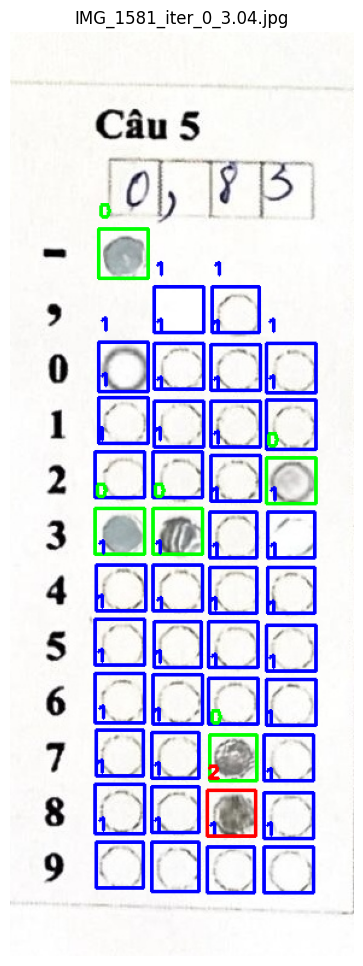

Saved the updated DataFrame to 'data/df_missing_updated.csv'


In [103]:
input_label_dir = "data/noduplicate_labels"            # Directory with original label files
output_label_dir = "data/std_num_bbox_labels"          # Directory to save updated label files
csv_output_path = "data/df_missing_updated.csv"            # Path to save the updated CSV file
cropped_image_dir = "data/cropped_images"                      # Directory containing the original images

# Create the output and trash directories if they don't exist
os.makedirs(output_label_dir, exist_ok=True)
os.makedirs("data/trash", exist_ok=True)
print(f"Output directory set to '{output_label_dir}'")
print(f"Trash directory set to 'data/trash'")

# Process and display the first entry (index 0)
process_and_display_first_entry(missing_df, cropped_image_dir, output_label_dir, id=0)

# Optionally, save the updated DataFrame to a new CSV
missing_df.to_csv(csv_output_path, index=False)
print(f"Saved the updated DataFrame to '{csv_output_path}'")


#### Process

In [104]:
import os

def sort_and_merge_selected_bboxes(label_path, output_label_path):
    """
    Sorts bounding boxes vertically, selects a subset, sorts the subset horizontally,
    merges the second and third bounding boxes in the subset by averaging their coordinates and sizes,
    adds the merged bounding box with class_id=2 to the list without replacing any existing ones,
    and saves the updated bounding boxes.
    
    Steps:
    1. Sort all bounding boxes vertically (by y_center_norm ascending).
    2. Select bounding boxes from index -7 to -5 (inclusive) as a subset.
    3. Sort this subset horizontally (by x_center_norm ascending).
    4. Merge the second and third bounding boxes in the sorted subset by averaging their coordinates and sizes.
    5. Add the merged bounding box with class_id=2 to the list without replacing any existing ones.
    6. Save the updated bounding boxes.
    
    Args:
        label_path (str): Path to the original label file.
        output_label_path (str): Path to save the updated label file.
        
    Returns:
        int: Number of bounding boxes retained after processing.
             Returns -1 if the label file is not found.
             Returns 0 if no valid bounding boxes are found.
    """
    try:
        with open(label_path, 'r') as f:
            labels = [line.strip() for line in f if line.strip()]
    except FileNotFoundError:
        print(f"Error: Label file not found: {label_path}")
        return -1  # Indicate failure to process
    
    # Parse labels into a list of tuples (class_id, x_center_norm, y_center_norm, width_norm, height_norm)
    parsed_labels = []
    for label in labels:
        parts = label.split()
        if len(parts) != 5:
            print(f"Skipping malformed label: '{label}' in '{label_path}'")
            continue  # Skip malformed lines
        class_id, x_center_norm, y_center_norm, width_norm, height_norm = parts
        try:
            x_center_norm_float = float(x_center_norm)
            y_center_norm_float = float(y_center_norm)
            width_norm_float = float(width_norm)
            height_norm_float = float(height_norm)
            parsed_labels.append((class_id, x_center_norm_float, y_center_norm_float, width_norm_float, height_norm_float))
        except ValueError:
            print(f"Skipping label with invalid float values: '{label}' in '{label_path}'")
            continue  # Skip labels with invalid float values
    
    if not parsed_labels:
        print(f"No valid bounding boxes found in '{label_path}'.")
        return 0  # Indicate no labels processed
    
    # Step 1: Sort all bounding boxes vertically (by y_center_norm ascending)
    sorted_vertically = sorted(parsed_labels, key=lambda x: x[2])
    
    # Step 2: Select bounding boxes from index -7 to -5 (inclusive) as a subset
    if len(sorted_vertically) < 5:
        print(f"Not enough bounding boxes to perform subset selection in '{label_path}'. No merging performed.")
        cleaned_labels = sorted_vertically  # No changes
    else:
        # Determine subset indices
        subset_start = max(len(sorted_vertically) - 7, 0)
        subset_end = max(len(sorted_vertically) - 4, 0)  # Exclusive in slicing
        
        subset = sorted_vertically[subset_start:subset_end]  # This will get up to 3 boxes: indices -7, -6, -5
        
        # Step 3: Sort this subset horizontally (by x_center_norm ascending)
        sorted_subset_horizontally = sorted(subset, key=lambda x: x[1])
        
        # Step 4: Merge the second and third bounding boxes in the sorted subset
        if len(sorted_subset_horizontally) < 3:
            print(f"Not enough bounding boxes in the subset to perform merging in '{label_path}'. No merging performed.")
            merged_box = None
        else:
            box1 = sorted_subset_horizontally[1]
            box2 = sorted_subset_horizontally[2]
            
            # Compute the mean of the second and third boxes
            merged_class_id = "2"  # Set class_id to 2 for the merged box
            merged_x_center_norm = (box1[1] + box2[1]) / 2
            merged_y_center_norm = (box1[2] + box2[2]) / 2
            merged_width_norm = (box1[3] + box2[3]) / 2
            merged_height_norm = (box1[4] + box2[4]) / 2
            
            merged_box = (merged_class_id, merged_x_center_norm, merged_y_center_norm, merged_width_norm, merged_height_norm)
    
    # Step 5: Add the merged bounding box to the list without replacing
    if 'merged_box' in locals() and merged_box:
        cleaned_labels = sorted_vertically + [merged_box]
    else:
        cleaned_labels = sorted_vertically  # No changes

    # Convert back to string format with six decimal places
    cleaned_labels_str = [
        f"{cls} {x:.6f} {y:.6f} {w:.6f} {h:.6f}"
        for cls, x, y, w, h in cleaned_labels
    ]
    
    # Step 6: Save the updated labels
    with open(output_label_path, 'w') as f:
        for label in cleaned_labels_str:
            f.write(label + '\n')
    
    print(f"Updated label file saved to '{output_label_path}'. Total labels retained: {len(cleaned_labels_str)}")
    return len(cleaned_labels_str)  # Return the number of labels retained

def process_bulk_labels(df, input_label_dir, output_label_dir):
    """
    Processes all label files listed in the DataFrame by sorting bounding boxes vertically,
    selecting and sorting a subset horizontally, merging specific bounding boxes, adding the merged
    bounding box, and saving the updated labels to the output directory.
    
    Args:
        df (pd.DataFrame): DataFrame containing image and label information.
        input_label_dir (str): Directory containing the original label files.
        output_label_dir (str): Directory to save the updated label files.
    
    Returns:
        int: Number of label files successfully processed.
    """
    processed_count = 0
    skipped_count = 0  # To track files that couldn't be processed
    
    # Ensure the output directory exists
    os.makedirs(output_label_dir, exist_ok=True)
    
    for idx, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing Labels"):
        label_name = row['label_name']
        input_label_path = os.path.join(input_label_dir, label_name)
        output_label_path = os.path.join(output_label_dir, label_name)  # Keeping the same file name
    
        retained_labels = sort_and_merge_selected_bboxes(input_label_path, output_label_path)
        if retained_labels > 0:
            # Update the DataFrame with the new number of labels
            df.at[idx, 'number_label'] = retained_labels
            df.at[idx, 'standard_number_label'] = retained_labels  # Adjust if needed
            processed_count += 1
        elif retained_labels == 0:
            print(f"No labels retained after processing '{label_name}'.")
            df.at[idx, 'number_label'] = 0
            df.at[idx, 'standard_number_label'] = 0
            skipped_count += 1
        else:
            print(f"Failed to process label file: {label_name}")
            skipped_count += 1
    
    print(f"\nBulk processing completed. Total files processed: {processed_count}")
    if skipped_count > 0:
        print(f"Total files skipped or failed to process: {skipped_count}")
    
    return processed_count

In [105]:
if RERUN:
    # Define directories
    input_label_dir = "data/noduplicate_labels"            # Directory with original label files
    output_label_dir = "data/std_num_bbox_labels"          # Directory to save updated label files
    csv_output_path = "data/df_missing_updated.csv"            # Path to save the updated CSV file

    # Create the output directory if it doesn't exist
    if not os.path.exists(output_label_dir):
        os.makedirs(output_label_dir)
        print(f"Created output directory: '{output_label_dir}'")
    else:
        print(f"Output directory already exists: '{output_label_dir}'")

    # Process all label files
    processed_files = process_bulk_labels(missing_df, input_label_dir, output_label_dir)
    print(f"\nBulk processing completed. Total files processed: {processed_files}")

    # Save the updated DataFrame to a new CSV
    missing_df.to_csv(csv_output_path, index=False)
    print(f"Saved the updated DataFrame to '{csv_output_path}'")

Output directory already exists: 'data/std_num_bbox_labels'


Processing Labels:   4%|▍         | 11/260 [00:00<00:02, 102.00it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_0_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_100_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_101_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_102_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_103_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_104_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_105_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_106_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_107_3.04.txt'. Total labels retained: 43
Updated label file sa

Processing Labels:  13%|█▎        | 33/260 [00:00<00:02, 100.73it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_117_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_118_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_119_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_11_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_120_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_121_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_122_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_123_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_124_3.04.txt'. Total labels retained: 43
Updated label file s

Processing Labels:  21%|██        | 54/260 [00:00<00:02, 99.02it/s] 

Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_134_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_135_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_136_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_137_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_138_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_139_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_13_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_140_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_141_3.04.txt'. Total labels retained: 43
Updated label file s

Processing Labels:  28%|██▊       | 74/260 [00:00<00:02, 91.41it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_154_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_155_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_156_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_157_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_158_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_159_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_15_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_160_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_161_3.04.txt'. Total labels retained: 43
Updated label file s

Processing Labels:  37%|███▋      | 95/260 [00:00<00:01, 95.62it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_171_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_172_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_173_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_174_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_175_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_176_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_177_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_178_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_179_3.04.txt'. Total labels retained: 43
Updated label file 

Processing Labels:  45%|████▍     | 116/260 [00:01<00:01, 90.45it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_191_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_192_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_193_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_194_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_195_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_196_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_197_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_198_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_199_3.04.txt'. Total labels retained: 43
Updated label file 

Processing Labels:  52%|█████▏    | 136/260 [00:01<00:01, 94.24it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_207_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_208_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_209_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_20_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_210_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_211_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_212_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_213_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_214_3.04.txt'. Total labels retained: 43
Updated label file s

Processing Labels:  60%|██████    | 157/260 [00:01<00:01, 97.02it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_227_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_228_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_229_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_22_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_230_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_231_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_232_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_233_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_234_3.04.txt'. Total labels retained: 43
Updated label file s

Processing Labels:  68%|██████▊   | 178/260 [00:01<00:00, 97.31it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_244_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_245_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_246_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_247_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_248_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_249_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_24_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_250_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_251_3.04.txt'. Total labels retained: 43
Updated label file s

Processing Labels:  77%|███████▋  | 199/260 [00:02<00:00, 97.72it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_29_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_2_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_30_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_31_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_32_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_33_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_34_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_35_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_36_3.04.txt'. Total labels retained: 43
Updated label file saved to '

Processing Labels:  84%|████████▍ | 219/260 [00:02<00:00, 94.94it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_48_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_49_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_4_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_50_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_51_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_52_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_53_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_54_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_55_3.04.txt'. Total labels retained: 43
Updated label file saved to '

Processing Labels:  92%|█████████▏| 239/260 [00:02<00:00, 96.30it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_66_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_67_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_68_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_69_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_6_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_70_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_71_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_72_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_73_3.04.txt'. Total labels retained: 43
Updated label file saved to '

Processing Labels: 100%|██████████| 260/260 [00:02<00:00, 96.18it/s]

Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_85_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_86_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_87_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_88_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_89_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_8_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_90_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_91_3.04.txt'. Total labels retained: 43
Updated label file saved to 'data/std_num_bbox_labels\IMG_1581_iter_92_3.04.txt'. Total labels retained: 43
Updated label file saved to '

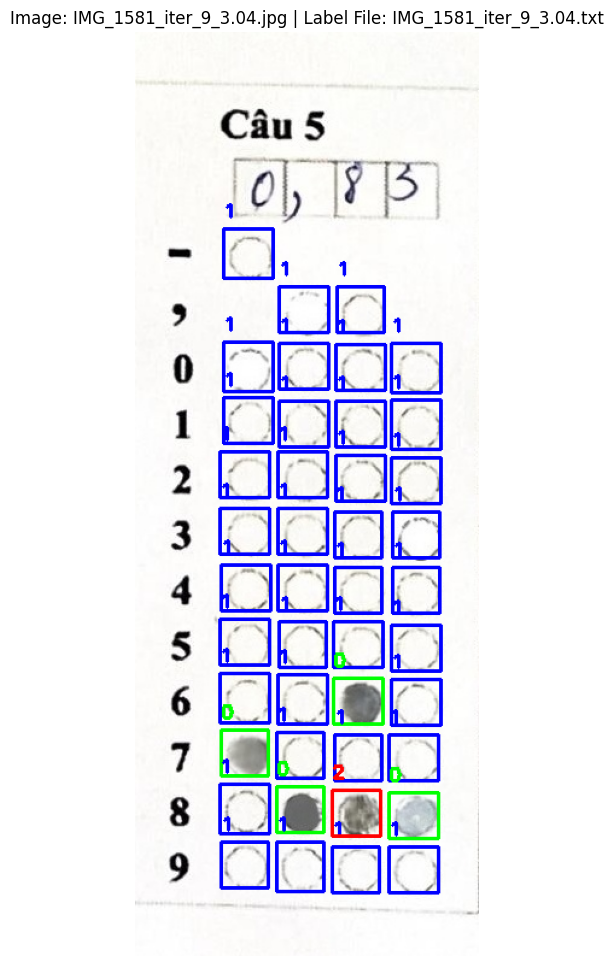

In [111]:
cropped_image_dir = "data/cropped_images"         # Directory with original images
output_label_dir = "data/std_num_bbox_labels"
display_first_entry(missing_df, cropped_image_dir, output_label_dir,id=259)